In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable

In [2]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [4]:
cols_to_use = ['IDMerged', 'tripIndex', 'actStartTime', 'actEndTime','duration_travelling', 'cost_BEAM', 'actStartType', 
               'actEndType', 'duration_walking', 'duration_in_privateCar', 'duration_on_bike', 'duration_in_ridehail', 
              'distance_travelling', 'duration_in_transit', 'distance_walking','distance_bike','distance_ridehail', 
              'distance_privateCar', 'distance_transit', 'mode_choice_planned_BEAM','mode_choice_actual_BEAM', 'vehicleIds',
              'numPassengers', 'distance_mode_choice', 'replanning_status', 'reason', 'parkingType',
               'BlockGroupStart','startX', 'startY', 'bgid_start', 'tractid_start', 'juris_name_start', 'county_name_start', 'mpo_start', 
               'BlockGroupEnd', 'endX', 'endY', 'bgid_end', 'tractid_end', 'juris_name_end', 'county_name_end', 'mpo_end',  
               'duration_door_to_door', 'waitTime_no_replanning', 'waitTime_replanning', 'actPurpose', 
               'mode_choice_actual_6', 'mode_choice_actual_5', 'mode_choice_actual_4', 
               'trip_id','person_id','household_id','tour_id','primary_purpose_x','destination_logsum_x', 'trip_mode_AS_trips', 
               'logsum_trip_Potential_INEXUS', 'tour_mode_AS_tours','duration','earning','sex','race_id', 'race',
               'TAZ_x','home_x','home_y','home_taz','value_of_time', 'school_taz','workplace_taz', 'free_parking_at_work',
               'hh_size','hh_income','income_in_thousands','median_value_of_time', 'hh_value_of_time', 'home_is_urban',
               'home_is_rural', 'auto_ownership','age', 'income', 'hh_cars', 'origin_x', 
               'destination_x', 'TAZ_y', 'DRIVEALONEFREE', 'scenario', 'year', 'lever_position_price', 
               'lever_position_fleetsize', 'door_to_door_time_relative_to_baseline', 'mandatoryCat', 'tour_category',
               'DRIVEALONEPAY', 'SHARED2FREE', 'SHARED2PAY', 'SHARED3FREE', 'SHARED3PAY', 'WALK', 'BIKE', 'WALK_LOC', 'WALK_LRF', 
               'WALK_EXP', 'WALK_HVY', 'WALK_COM', 'DRIVE_LOC', 'DRIVE_LRF', 'DRIVE_EXP', 'DRIVE_HVY', 'DRIVE_COM', 'TAXI',
               'TNC_SINGLE', 'TNC_SHARED', 'income_quartiles', 'income_deciles'] # Specify the columns to read

In [5]:
#%%time
# Original stacked file
#stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_rh_price_orig = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_5_5_23.csv', usecols = cols_to_use) #usecols = cols_to_use

In [6]:
%%time
# Stacked File without outliers (removed by isolation forest)
stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
sf_stacked_rh_price = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_clean_ML_5_11_23.csv') #usecols = cols_to_use

<timed exec>:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 13min 15s
Wall time: 54min


In [7]:
# remove the outliers
sf_stacked_rh_price = sf_stacked_rh_price[(sf_stacked_rh_price['duration_travelling'] > 0)].reset_index(drop=True)

In [8]:
# Remove the outliers
sf_stacked_rh_price = sf_stacked_rh_price[(sf_stacked_rh_price['duration_walking'] < 3600)&(sf_stacked_rh_price['distance_walking'] < 5000)]

#### Figure 5 - Density plot of the Potential INEXUS and income level

In [25]:
# We only chose three scenarios for this plot to show the differences more clearly
plot_inc_3 = sf_stacked_rh_price[(sf_stacked_rh_price['lever_position_price'] == 0)|
                         (sf_stacked_rh_price['lever_position_price'] == 1)|(sf_stacked_rh_price['lever_position_price'] == 8)]

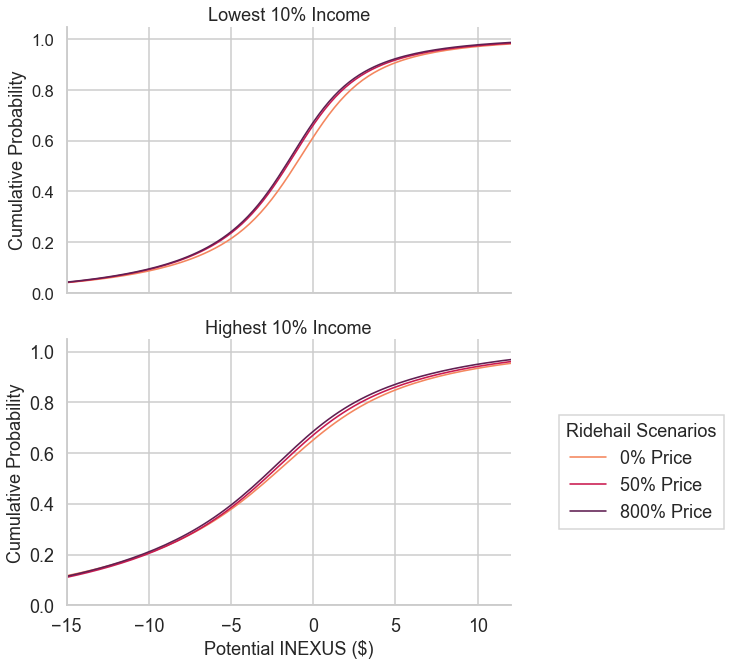

In [24]:
##### sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')],
                     row = 'income_deciles',
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =3, linewidth = 1.6, cumulative=True)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,12))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price','50% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Cumulative Probability', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

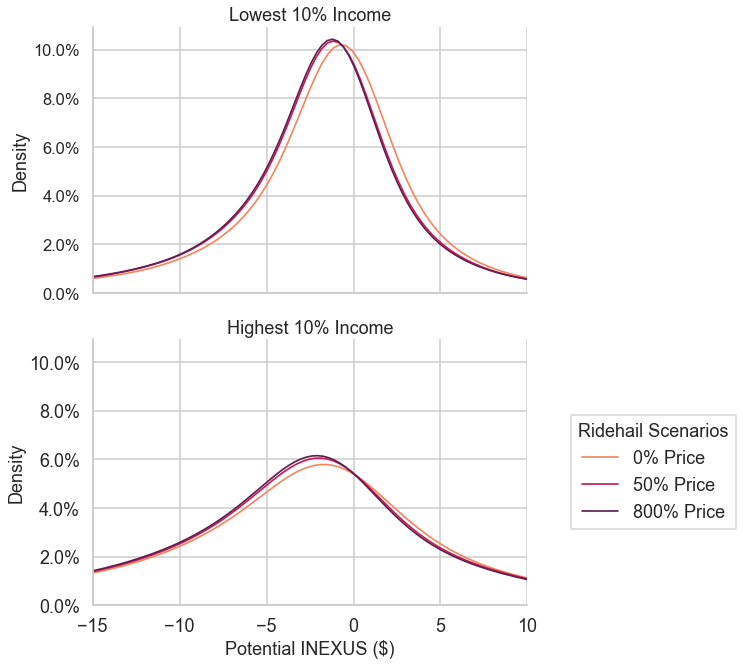

In [15]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =3, linewidth = 1.7)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '50% Price','800% Price'],
           #'0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

#### Check

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_cleaned_rm_ouliers, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_cleaned_rm_ouliers[(sfbase_cleaned_rm_ouliers['income_deciles']=='1stD')|(sfbase_cleaned_rm_ouliers['income_deciles']=='10thD')], x="Potential_INEXUS_in_dollar", 
            hue = 'income_deciles',fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Highest 10% Income','Lowest 10% Income'], loc="best", ncol=1, title=None, frameon=True, fontsize = 36) #bbox_to_anchor=(1.25, 0.6)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

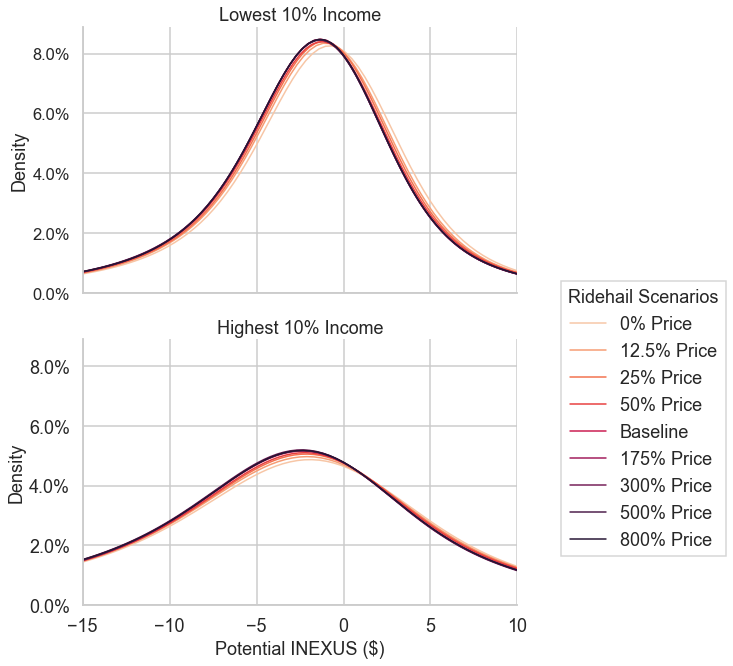

In [40]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc.loc[(plot_inc['income_deciles'] == '1stD')|
                                    (plot_inc['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [30]:
sf_stacked_rh_price['income_level'] = np.where(sf_stacked_rh_price['income']>= 94000, 'High Income', 'Low Income')

In [66]:
%%time
sf_stacked_rh_price_clean1['realized_in_dollar_2023_relative_to_baseline'] = sf_stacked_rh_price_clean1['Realized_INEXUS_in_dollar_2023'] - (sf_stacked_rh_price_clean1['Realized_INEXUS_in_dollar_2023'].where(sf_stacked_rh_price_clean1['lever_position_price'].eq(1.0))
                                                                                                  .groupby([sf_stacked_rh_price_clean1['IDMerged'],sf_stacked_rh_price_clean1['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes()) 

CPU times: total: 2min 35s
Wall time: 2min 35s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [67]:
%%time
sf_stacked_rh_price_clean1['potential_in_dollar_2023_relative_to_baseline'] = sf_stacked_rh_price_clean1['Potential_INEXUS_in_dollar_2023'] - (sf_stacked_rh_price_clean1['Potential_INEXUS_in_dollar_2023'].where(sf_stacked_rh_price_clean1['lever_position_price'].eq(1.0))
                                                                                                  .groupby([sf_stacked_rh_price_clean1['IDMerged'],sf_stacked_rh_price_clean1['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes()) 

CPU times: total: 2min 36s
Wall time: 2min 35s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
sf_stacked_rh_price_clean1["mode_actual_baseline"] = np.where(sf_stacked_rh_price_clean1['lever_position_price']==1, sf_stacked_rh_price_clean1["mode_choice_actual_BEAM"], None)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_5136\1302169689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_stacked_rh_price_clean1["mode_actual_baseline"] = np.where(sf_stacked_rh_price_clean1['lever_position_price']==1, sf_stacked_rh_price_clean1["mode_choice_actual_BEAM"], None)


In [69]:
%%time
sf_stacked_rh_price_clean1["mode_actual_baseline"] = sf_stacked_rh_price_clean1.groupby(['IDMerged','tripIndex'])['mode_actual_baseline'].transform(lambda x: x.ffill().bfill())

CPU times: total: 17min 10s
Wall time: 17min 12s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
%%time
same_mode_actual = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['mode_actual_baseline'] == sf_stacked_rh_price_clean1['mode_choice_actual_BEAM']]

CPU times: total: 12.3 s
Wall time: 12.3 s


#### Outlier Methods

In [ ]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_stacked_rh_price_clean1[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_stacked_rh_price_clean1['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
df_clean_0p01 = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['is_outlier'] == 1]

In [ ]:
df_clean_0p01.groupby('lever_position_price').size()

In [ ]:
sf_stacked_rh_price_clean1.groupby('lever_position_price').size()

In [ ]:
# Calculate the median absolute deviation (MAD) for each column
mad_1 = np.median(np.abs(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] - np.median(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'])))
mad_2 = np.median(np.abs(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] - np.median(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'])))

# Define the outlier threshold as 3 times the MAD
threshold_1 = 3 * mad_1
threshold_2 = 3 * mad_2

# Filter out the data points that are outliers for both columns
df_MAD = sf_stacked_rh_price_cleaned[(np.abs(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] - np.median(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'])) < threshold_1) &
          (np.abs(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] - np.median(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'])) < threshold_2)]

In [ ]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
df_short = sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

In [ ]:
# Group the dataframe by lever_position_price
groups = sf_stacked_rh_price_cleaned.groupby('lever_position_price')

# Define a function to filter outliers
def filter_group(group):
    # Calculate the first and third quartiles and the IQR for each column
    q1_col1, q3_col1 = np.percentile(group['Potential_INEXUS_in_dollar_2023'], [25, 75])
    iqr_col1 = q3_col1 - q1_col1
    q1_col2, q3_col2 = np.percentile(group['Realized_INEXUS_in_dollar_2023'], [25, 75])
    iqr_col2 = q3_col2 - q1_col2
    
    # Define the lower and upper bounds for outliers for each column
    lower_bound_col1 = q1_col1 - 1.5 * iqr_col1
    upper_bound_col1 = q3_col1 + 1.5 * iqr_col1
    lower_bound_col2 = q1_col2 - 1.5 * iqr_col2
    upper_bound_col2 = q3_col2 + 1.5 * iqr_col2
    
    # Count the number of data points in the group that are within the bounds for each column
    within_bounds_count_col1 = group[(group['Potential_INEXUS_in_dollar_2023'] >= lower_bound_col1) & (group['Potential_INEXUS_in_dollar_2023'] <= upper_bound_col1)].shape[0]
    within_bounds_count_col2 = group[(group['Realized_INEXUS_in_dollar_2023'] >= lower_bound_col2) & (group['Realized_INEXUS_in_dollar_2023'] <= upper_bound_col2)].shape[0]
    
    # Calculate the percentage of data points within the bounds for each column
    within_bounds_percent_col1 = within_bounds_count_col1 / group.shape[0]
    within_bounds_percent_col2 = within_bounds_count_col2 / group.shape[0]
    
    # If the percentage of data points within the bounds is less than 0.5, increase the lower bound
    # and if it's greater than 0.5, decrease the upper bound to keep the distribution of data points
    # in the group as close to the original as possible
    if within_bounds_percent_col1 < 0.5:
        lower_bound_col1 = q1_col1 - (within_bounds_count_col1 / group.shape[0]) * iqr_col1
    elif within_bounds_percent_col1 > 0.5:
        upper_bound_col1 = q3_col1 + (within_bounds_count_col1 / group.shape[0]) * iqr_col1
        
    if within_bounds_percent_col2 < 0.5:
        lower_bound_col2 = q1_col2 - (within_bounds_count_col2 / group.shape[0]) * iqr_col2
    elif within_bounds_percent_col2 > 0.5:
        upper_bound_col2 = q3_col2 + (within_bounds_count_col2 / group.shape[0]) * iqr_col2
    
    # Filter the data points that are outside the bounds for each column
    group = group[(group['Potential_INEXUS_in_dollar_2023'] >= lower_bound_col1) & (group['Potential_INEXUS_in_dollar_2023'] <= upper_bound_col1) & 
                  (group['Realized_INEXUS_in_dollar_2023'] >= lower_bound_col2) & (group['Realized_INEXUS_in_dollar_2023'] <= upper_bound_col2)]
    
    return group

# Apply the filter_group function to each group
filtered_df = groups.apply(filter_group)

# Remove the groupby index
filtered_df.reset_index(drop=True, inplace=True)

In [ ]:
#plt.boxplot(dfout2['Potential_INEXUS_in_dollar_2023'], whis=3)
#plt.show()

In [ ]:
filtered_df.groupby('lever_position_price').size()

In [ ]:
df_short.groupby('lever_position_price').size()

In [ ]:
df_clean_0p01.groupby('lever_position_price').size()

In [ ]:
#lower_percentile_realized_dollar = sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar'].quantile(0.05)
#upper_percentile_realized_dollar = sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar'].quantile(0.95)
#df_filtered = sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar'] >= lower_percentile_realized_dollar) & (sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar'] <= upper_percentile_realized_dollar)]

In [ ]:
#df_filtered.Realized_INEXUS_in_dollar.describe()

In [ ]:
#filtered_df.groupby('lever_position_price')['realized_in_dollar_relative_to_baseline'].describe()

In [ ]:
#filtered_df.groupby('lever_position_price')['potential_in_dollar_relative_to_baseline'].describe()

In [ ]:
#sf_stacked_rh_price_cleaned.groupby(['lever_position_price','mode_choice_actual_BEAM'])['realized_in_dollar_relative_to_baseline'].describe()

In [ ]:
#df_filtered.potential_in_dollar_relative_to_baseline.describe()

In [ ]:
#sf_stacked_rh_price = sf_stacked_rh_price[(sf_stacked_rh_price['Realized_INEXUS'] > -80).groupby(sf_stacked_rh_price.IDMerged).transform('all')]

In [ ]:
#sf_stacked_rh_price['log_Realized_INEXUS_in_dollar'] = sf_stacked_rh_price.loc[:,'Realized_INEXUS_in_dollar'].apply(np.log)
#sf_stacked_rh_price['log_Social_INEXUS'] = sf_stacked_rh_price.loc[:,'Social_INEXUS'].apply(np.log)

In [ ]:
sf_stacked_rh_price_cleaned.duration_walking.describe()

In [ ]:
sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['mode_choice_actual_BEAM'] == 'walk') & (sf_stacked_rh_price_cleaned['cost_BEAM']>0)]['duration_walking'].mean()

In [ ]:
#sf_stacked_rh_price.groupby(['mode_choice_actual_BEAM'])['cost_BEAM'].describe()

In [ ]:
#cost_mode.to_csv('C:/Shared-Work/Data/CleanData/cost_mode.csv')

In [ ]:
sf_stacked_rh_price_cleaned.lever_position_price.unique()

In [ ]:
# Summary Table
grouped = df.groupby(['lever_position_price','income_deciles','mode_choice_actual_BEAM'])

In [ ]:
# Compute summary statistics for each group
summary_table_rh_price = grouped.agg({'socialCarbonCost': 'mean', 
                                      'fuel_marginal': 'sum',
                                      'fuelGasoline': 'sum',
                                      'fuelDiesel': 'sum',
                                      'fuelElectricity': 'sum',
                                      'fuelFood': 'sum',
                                      'fuelBiodiesel': 'sum',
                                      'emissionFood': 'sum',
                                      'emissionElectricity': 'sum',
                                      'emissionDiesel': 'sum',
                                      'emissionGasoline': 'sum',
                                      'emissionBiodiesel': 'sum',
                                      'emission_marginal': 'sum',
                                      'duration_travelling': 'mean',
                                      'duration_door_to_door': 'mean',
                                      'duration_walking': 'mean',
                                      'duration_in_privateCar': 'mean',
                                      'duration_on_bike': 'mean',
                                      'duration_in_ridehail': 'mean',
                                      'duration_in_transit': 'mean',
                                      'waitTime_no_replanning': 'mean',
                                      'waitTime_replanning': 'mean',
                                      'distance_travelling': 'mean',
                                      'distance_walking': 'mean',
                                      'distance_bike': 'mean', 
                                      'distance_ridehail': 'mean',
                                      'distance_privateCar': 'mean',
                                      'distance_transit': 'mean',
                                      'cost_BEAM': 'mean',
                                      'Realized_INEXUS': 'mean',
                                      'alpha': 'mean',
                                      'Social_INEXUS': 'mean',
                                      'Potential_INEXUS_in_dollar': 'mean',
                                      'Realized_INEXUS_in_dollar': 'mean',
                                     })

In [ ]:
#Rename the columns of the summary table
summary_table_rh_price = summary_table_rh_price.rename(columns={'socialCarbonCost': 'Avg Fuel Consumption', 
                                                                'marginal emissions': 'Total Marginal Emissions', 
                                                                'distance': 'Total Distance', 
                                                                'travel time': 'Avg Travel Time',
                                                                })

# Sort the summary table by a particular column
#summary_table = summary_table.sort_values(by='Total Distance', ascending=False)

#### Consumer Surplus and Social Cost Change

In [ ]:
#sf_stacked_rh_price_cleaned.groupby(['lever_position_price','mode_choice_actual_BEAM'])['socialCarbonCost'].describe()

In [ ]:
same_mode_actual[same_mode_actual['cost_BEAM'].isna()].shape

In [ ]:
same_mode_actual[same_mode_actual['mode_choice_actual_BEAM'] == 'ride_hail_pooled'].groupby('lever_position_price')['cost_BEAM'].describe()

In [ ]:
diff_mode_actual = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['mode_actual_baseline'] != sf_stacked_rh_price_clean1['mode_choice_actual_BEAM']]

In [ ]:
#sf_stacked_rh_price_cleaned.groupby(['lever_position_price','income_deciles'])['socialCarbonCost'].sum()

In [ ]:
#sf_stacked_rh_price_cleaned.groupby(['lever_position_price','mode_choice_actual_BEAM'])['socialCarbonCost'].sum()

In [ ]:
income_decile = '1stD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == position) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'socialCarbonCost'].sum()
    baseline_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == 1) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'socialCarbonCost'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario cost for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
income_decile = '10thD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == position) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'socialCarbonCost'].sum()
    baseline_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == 1) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'socialCarbonCost'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario cost for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
#lever_positions = [0, 0.125, 0.25, 0.5, 1.75, 3, 5, 8]

#for position in lever_positions:
    #scenario_cost = sf_stacked_rh_price_clean1.loc[sf_stacked_rh_price_clean1['lever_position_price'] == position, 'socialCarbonCost'].sum()
    #baseline_cost = sf_stacked_rh_price_clean1.loc[sf_stacked_rh_price_clean1['lever_position_price'] == 1, 'socialCarbonCost'].sum()
    #difference = scenario_cost - baseline_cost
    #print(f"Scenario cost for lever position {position}: {scenario_cost:.2f}")
    #print(f"Difference from baseline: {difference:.2f}")

In [ ]:
sf_stacked_rh_price_cleaned['IDMerged'].nunique()

In [ ]:
sf_stacked_rh_price_cleaned[sf_stacked_rh_price_cleaned['income_deciles']=='1stD']['IDMerged'].nunique()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
fig, ax = plt.subplots()
ax = sns.lineplot(data = social_cost_sum.loc[(social_cost_sum['income_deciles']=='1stD')|
                                            (social_cost_sum['income_deciles']=='10thD')], x = 'lever_position_price', 
                  y = 'socialCarbonCost', hue = 'income_deciles', palette = 'rocket', marker='o', ci=None, linewidth = 6, markersize= 20)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Social cost of carbon (sum)', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 40})
plt.savefig('social_cost_income.svg', format='svg')
plt.savefig('social_cost_income.png', dpi=500)

In [ ]:
# Consumer Surplus

In [ ]:
income_decile = '10thD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == position) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar'].sum()
    baseline_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == 1) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
income_decile = '1stD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == position) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar'].sum()
    baseline_cost = sf_stacked_rh_price_cleaned.loc[(sf_stacked_rh_price_cleaned['lever_position_price'] == 1) & (sf_stacked_rh_price_cleaned['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_clean1.loc[sf_stacked_rh_price_clean1['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked_rh_price_clean1.loc[sf_stacked_rh_price_clean1['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
sf_stacked_rh_price_clean1_ridehail = sf_stacked_rh_price_clean1[(sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail')|
                          (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

In [ ]:
sf_stacked_rh_price_clean1_ridehail.IDMerged.nunique()

In [ ]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price_clean1_ridehail.loc[sf_stacked_rh_price_clean1_ridehail['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked_rh_price_clean1_ridehail.loc[sf_stacked_rh_price_clean1_ridehail['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
same_mode_actual_rh = same_mode_actual[(same_mode_actual['mode_choice_actual_BEAM'] == 'ride_hail')|
                          (same_mode_actual['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

In [ ]:
same_mode_actual_rh.IDMerged.nunique()

In [ ]:
# total change for non-switchers
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = same_mode_actual_rh.loc[same_mode_actual_rh['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = same_mode_actual_rh.loc[same_mode_actual_rh['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
diff_mode_actual_rh = diff_mode_actual[(diff_mode_actual['mode_choice_actual_BEAM'] == 'ride_hail')|
                          (diff_mode_actual['mode_choice_actual_BEAM'] == 'ride_hail_pooled')]

In [ ]:
diff_mode_actual_rh.IDMerged.nunique()

In [ ]:
# total change for non-switchers
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = diff_mode_actual_rh.loc[diff_mode_actual_rh['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = diff_mode_actual_rh.loc[diff_mode_actual_rh['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
low_sf_stacked_rh_price_clean1 = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['income_deciles'] == '1stD']

In [ ]:
low_sf_stacked_rh_price_clean1[(low_sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail')|
                          (low_sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail_pooled')].IDMerged.nunique()

In [ ]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = low_sf_stacked_rh_price_clean1.loc[low_sf_stacked_rh_price_clean1['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = low_sf_stacked_rh_price_clean1.loc[low_sf_stacked_rh_price_clean1['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
high_sf_stacked_rh_price_clean1 = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['income_deciles'] == '10thD']

In [ ]:
high_sf_stacked_rh_price_clean1.IDMerged.nunique()

In [ ]:
high_sf_stacked_rh_price_clean1[(high_sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail')|
                          (high_sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail_pooled')].IDMerged.nunique()

In [ ]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = high_sf_stacked_rh_price_clean1.loc[high_sf_stacked_rh_price_clean1['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = high_sf_stacked_rh_price_clean1.loc[high_sf_stacked_rh_price_clean1['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
def to_percent(y, position):
    return '{:.2f}%'.format(y * 100) # for two decimal places

In [ ]:
cd = sf_stacked_rh_price_clean1.groupby(['lever_position_price', 'income_deciles'])['mode_choice_actual_BEAM'].value_counts(normalize=True,sort=False).reset_index(name='Percentage')

In [ ]:
rh_share = cd[(cd['mode_choice_actual_BEAM']=='ride_hail')|(cd['mode_choice_actual_BEAM']=='ride_hail_pooled')].groupby(['lever_position_price', 'income_deciles'])['Percentage'].sum().reset_index(name='rh_share')

In [ ]:
#rh_agent_share = sf_stacked_rh_price_clean1[(sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail') | (cd['mode_choice_actual_BEAM'] == 'ride_hail_pooled')] \
              #.groupby(['lever_position_price', 'income_deciles']) \
              #.agg({'Percentage': 'sum', 'IDMerged': 'nunique'}) \
              #.reset_index() \
              #.rename(columns={'Percentage': 'rh_share', 'IDMerged': 'total_agents'}) \
              #.assign(rh_share_percent=lambda x: x['rh_share'] / x['total_agents'] * 100)

In [ ]:
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
sns.set_palette("turbo")
ax = sns.lineplot(data = rh_share.loc[(rh_share['income_deciles']=='1stD')|
                                   (rh_share['income_deciles']=='10thD')], x = 'lever_position_price', 
                  y = 'rh_share', marker='o', hue = 'income_deciles',
                  markersize=20, ci=None, linewidth = 6)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Share of trips using ridehail', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent))
plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 40})
plt.savefig('share_agents_ridehail_price_income.svg', format='svg')
plt.savefig('share_agents_ridehail_price_income.png', dpi=500)

In [ ]:
cd.mode_choice_actual_BEAM.unique()

In [ ]:
high_emission_share = cd[(cd['mode_choice_actual_BEAM'] == 'car')|
                        (cd['mode_choice_actual_BEAM'] == 'ride_hail')|
                        (cd['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|
                        (cd['mode_choice_actual_BEAM'] == 'car_hov2')|
                         (cd['mode_choice_actual_BEAM'] == 'car_hov3')].groupby(['lever_position_price', 'income_deciles'])['Percentage'].sum().reset_index(name='emission_share')

In [ ]:
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
sns.set_palette("turbo_r")
ax = sns.lineplot(data = high_emission_share.loc[(high_emission_share['income_deciles']=='1stD')|
                                   (high_emission_share['income_deciles']=='10thD')], x = 'lever_position_price', 
                  y = 'emission_share', marker='o', hue = 'income_deciles',
                  markersize=20, ci=None, linewidth = 6)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Share of trips using high emission modes', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent))
plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 40})
plt.savefig('share_agents_ridehail_price_emission.svg', format='svg')
plt.savefig('share_agents_ridehail_price_emission.png', dpi=500)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("mako_r")
ax = sns.lineplot(data = cd_plt.loc[cd_plt['mode_choice_actual_BEAM']=='ride_hail'], x = 'lever_position_price', hue= 'income_deciles', 
                  y = 'Percentage', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 18)
ax.set_ylabel('Share of agents for whom all the trips are by ridehail', fontsize = 18)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [ ]:
conditions  = [(sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'car_hov2')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'car_hov3')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'car'),
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'walk')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'bike'),
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail'),
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'ride_hail_pooled'),
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'walk_transit')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'bike_transit')|
               (sf_stacked_rh_price_clean1['mode_choice_actual_BEAM'] == 'drive_transit')]

choices = ['car', 'walk/bike', 'ride_hail', 'ride_hail_pooled', 'transit']

In [ ]:
sf_stacked_rh_price_clean1['mode_choice_actual_summarized'] = np.select(conditions, choices, default=np.nan)

In [ ]:
sf_stacked_rh_price_clean1["mode_actual_baseline_summarized"] = np.where(sf_stacked_rh_price_clean1['lever_position_price']==1, sf_stacked_rh_price_clean1["mode_choice_actual_summarized"], None)

In [ ]:
%%time
sf_stacked_rh_price_clean1["mode_actual_baseline_summarized"] = sf_stacked_rh_price_clean1.groupby(['IDMerged','tripIndex'])['mode_actual_baseline_summarized'].transform(lambda x: x.ffill().bfill())

In [ ]:
#sf_stacked_rh_price_clean1['mode_switch'] = sf_stacked_rh_price_clean1.apply(lambda x: f"{x['mode_actual_baseline']} -> {x['mode_choice_actual_BEAM']}" if x['mode_actual_baseline'] != x['mode_choice_actual_BEAM'] else None, axis=1)

In [ ]:
diff_mode_actual = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['mode_actual_baseline_summarized'] != sf_stacked_rh_price_clean1['mode_choice_actual_summarized']]
diff_mode_actual['baseline_to_choice'] = diff_mode_actual['mode_actual_baseline_summarized'] + ' -> ' + diff_mode_actual['mode_choice_actual_summarized']
diff_mode_actual.loc[diff_mode_actual['mode_actual_baseline_summarized'].isna() | diff_mode_actual['mode_choice_actual_summarized'].isna(), 'baseline_to_choice'] = np.nan

In [ ]:
diff_mode_actual.mode_choice_actual_summarized.unique()

In [ ]:
high_emission_modes = ['car', 'ride_hail', 'ride_hail_pooled']
low_emission_modes = ['transit', 'walk/bike']

In [ ]:
conditions = [diff_mode_actual['mode_actual_baseline_summarized'].isin(high_emission_modes)&
               diff_mode_actual['mode_choice_actual_summarized'].isin(high_emission_modes),
               diff_mode_actual['mode_actual_baseline_summarized'].isin(high_emission_modes)&
               diff_mode_actual['mode_choice_actual_summarized'].isin(low_emission_modes),
               diff_mode_actual['mode_actual_baseline_summarized'].isin(low_emission_modes)&
               diff_mode_actual['mode_choice_actual_summarized'].isin(low_emission_modes),
               diff_mode_actual['mode_actual_baseline_summarized'].isin(low_emission_modes)&
               diff_mode_actual['mode_choice_actual_summarized'].isin(high_emission_modes)]
                
choices = ['high emission', 'low emission', 'low emission', 'high emission']

In [ ]:
diff_mode_actual['emission_level']  = np.select(conditions, choices, default=np.nan)

In [ ]:
income_emission_plot_total = diff_mode_actual[(diff_mode_actual['income_deciles'] == '1stD')|
                          (diff_mode_actual['income_deciles'] == '10thD')]

In [ ]:
income_emission_plot_total_grouped = income_emission_plot_total.groupby(['lever_position_price', 'income_deciles', 'emission_level'])['tripIndex'].count().reset_index(name='count')
income_emission_plot_total_grouped['percentage'] = income_emission_plot_total_grouped.groupby(['lever_position_price', 'income_deciles'])['count'].apply(lambda x: 100 * x / x.sum())

In [ ]:
income_emission_plot_total_grouped

In [ ]:
df_pivot = plot_clean.pivot(index='lever_position_price', columns=['emission_level','income_deciles'], values='percentage')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palette
colors = ["#d73027", "#1a9850", "#FFA07A", "#b3de69"] 

# Plot the data with the specified color palette
sns.set_palette(sns.color_palette(colors))
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(17, 10))

# Set axis labels and tick parameters
ax.set_xlabel('Ridehail price multiplier',fontsize = 30)
ax.set_ylabel('Percentage of Emissions',fontsize = 30)
def to_percent_sign(y, position):
    return '{:.0f}%'.format(y)

ax.yaxis.set_tick_params(labelsize = 30)
ax.xaxis.set_tick_params(labelsize = 30)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent_sign))
ax.tick_params(axis='x', labelrotation=0)

# Add a legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 30)

plt.show()

In [ ]:
df_pivot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palette
colors = ["#d73027", "#1a9850", "#FFA07A", "#b3de69"] 

# Create two dataframes for low and high emissions
high_income = df_pivot.iloc[:, [0, 1]]
low_income = df_pivot.iloc[:, [2, 3]]

# Plot the low emissions dataframe
sns.set_palette(sns.color_palette(colors))
ax1 = low_income.plot(kind='bar', stacked=True, figsize=(17, 10))
ax1.set_xlabel('Ridehail price multiplier',fontsize = 30)
ax1.set_ylabel('Percentage of Emissions',fontsize = 30)
def to_percent_sign(y, position):
    return '{:.0f}%'.format(y)
ax1.yaxis.set_tick_params(labelsize = 30)
ax1.xaxis.set_tick_params(labelsize = 30)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent_sign))
ax1.tick_params(axis='x', labelrotation=0)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 30)
ax1.set_title('Lowest 10% income', fontsize=30)

# Plot the high emissions dataframe
sns.set_palette(sns.color_palette(colors))
ax2 = high_income.plot(kind='bar', stacked=True, figsize=(17, 10))
ax2.set_xlabel('Ridehail price multiplier',fontsize = 30)
ax2.set_ylabel('Percentage of Emissions',fontsize = 30)
def to_percent_sign(y, position):
    return '{:.0f}%'.format(y)
ax2.yaxis.set_tick_params(labelsize = 30)
ax2.xaxis.set_tick_params(labelsize = 30)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent_sign))
ax2.tick_params(axis='x', labelrotation=0)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 30)
ax2.set_title('Highest 10% income', fontsize=30)

plt.show()

In [ ]:
plot_clean = income_emission_plot_total_grouped.loc[(income_emission_plot_total_grouped['emission_level']!='nan')]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(data=plot_clean, col='income_deciles', col_wrap=3)
g.map(sns.lineplot, 'lever_position_price', 'percentage', 'emission_level', 
      marker='o', sizes=(3, 10), linewidth=6, markersize=20, ci=None)
g.set_xlabels('Ridehail price multiplier', fontsize=15)
g.set_ylabels('Percentage of trip modes switched from baseline', fontsize=15)
g.set_titles('{col_name} income decile')
g.set_xticklabels(fontsize=12)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
sns.set_palette("turbo_r")
def to_percent_sign(y, position):
    return '{:.0f}%'.format(y)
ax = sns.lineplot(data = plot_clean, 
                  x = 'lever_position_price', 
                  y = 'percentage', 
                  hue='income_deciles',
                  markers='o',
                  sizes=(3, 10), 
                  linewidth=6,
                  markersize=20, 
                  ci=None)
ax.set_xlabel('Ridehail price multiplier', fontsize = 37)
ax.set_ylabel('Percentage of trip modes switched from baseline', fontsize = 37)
plt.legend(fontsize=25, loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 25})
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent_sign))  # format y-axis ticks as percentages
ax.yaxis.set_tick_params(labelsize = 30)
ax.xaxis.set_tick_params(labelsize = 30)

In [ ]:
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
sns.set_palette("turbo_r")
ax = sns.lineplot(data = income_emission_plot_total, x = 'lever_position_price', 
                  y = 'percentage', marker='o', hue = 'income_deciles',size='emission_level',
                  sizes=(3, 10), legend='full',linewidth=6,
                  markersize=20, ci=None)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Share of agents switching to high emission modes', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent))
#plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         #fontsize='small', fancybox=False, bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 40})
#plt.savefig('share_agents_ridehail_price_emission.svg', format='svg')
#plt.savefig('share_agents_ridehail_price_emission.png', dpi=500)

In [ ]:
#diff_mode_actual.groupby(['lever_position_price', 'baseline_to_choice'])['tripIndex'].count().reset_index(name='count').sort_values(by=['lever_position_price', 'count'], ascending=[True, False])

In [ ]:
#diff_mode_actual_grouped = diff_mode_actual.groupby(['lever_position_price', 'baseline_to_choice'])['tripIndex'].count().reset_index(name='count').sort_values(by=['lever_position_price', 'count'], ascending=[True, False])
#diff_mode_actual_grouped['percentage'] = diff_mode_actual_grouped.groupby('lever_position_price')['count'].apply(lambda x: x / x.sum())

In [ ]:
ridehail_switches = diff_mode_actual.loc[(diff_mode_actual['mode_actual_baseline_summarized'] == 'ride_hail') | 
                                         (diff_mode_actual['mode_actual_baseline_summarized'] == 'ride_hail_pooled')|
                                         (diff_mode_actual['mode_choice_actual_summarized'] == 'ride_hail')|
                                         (diff_mode_actual['mode_choice_actual_summarized'] == 'ride_hail_pooled')]

In [ ]:
ridehail_switches_grouped = ridehail_switches.groupby(['lever_position_price', 'income_deciles', 'baseline_to_choice'])['tripIndex'].count().reset_index(name='count').sort_values(by=['lever_position_price', 'count'], ascending=[True, False])
ridehail_switches_grouped['percentage'] = ridehail_switches_grouped.groupby(['lever_position_price'])['count'].apply(lambda x: x / x.sum())

In [ ]:
ridehail_switches_grouped.to_csv('C:/Users/nrezaei/Documents/Data/ridehail_switches_grouped.csv', index = False)

In [ ]:
ridehail_switches_grouped

In [ ]:
ridehail_switches_grouped.baseline_to_choice.unique()

In [ ]:
high_emission_modes = ['car -> ride_hail', 'ride_hail -> car', 'transit -> ride_hail', 'walk/bike -> ride_hail', 
'ride_hail_pooled -> car', 'car -> ride_hail_pooled', 'ride_hail_pooled -> ride_hail', 'walk/bike -> ride_hail_pooled',
'transit -> ride_hail_pooled', 'ride_hail -> ride_hail_pooled']
low_emission_modes = ['ride_hail -> transit', 'ride_hail -> walk/bike', 'ride_hail_pooled -> walk/bike', 
'ride_hail_pooled -> transit']

In [ ]:
inc_emi_plot = ridehail_switches_grouped[(ridehail_switches_grouped['income_deciles'] == '1stD')|
                          (ridehail_switches_grouped['income_deciles'] == '10thD')]

In [ ]:
inc_emi_plot['emission_level'] = np.where(inc_emi_plot['baseline_to_choice'].isin(high_emission_modes), 'high emission',
                                 np.where(inc_emi_plot['baseline_to_choice'].isin(low_emission_modes), 'low emission', np.nan))

In [ ]:
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
sns.set_palette("turbo_r")
ax = sns.lineplot(data = inc_emi_plot, x = 'lever_position_price', 
                  y = 'percentage', marker='o', hue = 'income_deciles',size='emission_level',
                  sizes=(3, 10), legend='full',linewidth=6,
                  markersize=20, ci=None)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Share of agents switching to high emission modes', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(to_percent))
#plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         #fontsize='small', fancybox=False, bbox_to_anchor=(1.02, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 40})
#plt.savefig('share_agents_ridehail_price_emission.svg', format='svg')
#plt.savefig('share_agents_ridehail_price_emission.png', dpi=500)

In [ ]:
inc_emi_plot

#### Average number of modes plots

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.scatterplot(data=sf_stacked_rh_price, x="log_Realized_INEXUS_in_dollar", y="log_Social_INEXUS", hue="mode_choice_actual_4")

In [ ]:
%%time
sf_stacked_rh_price['social_cost_relative_to_baseline'] = sf_stacked_rh_price['socialCarbonCost'] - (sf_stacked_rh_price['socialCarbonCost'].where(sf_stacked_rh_price['lever_position'].eq(1.0))
                                                                                                  .groupby([sf_stacked_rh_price['IDMerged'],sf_stacked_rh_price['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes())

In [ ]:
agg = (sf_stacked_rh_price.groupby(['lever_position_price','IDMerged'])
         .agg({'mode_choice_actual_BEAM': 'nunique'})
      )

In [ ]:
agg = (sf_stacked_rh_price.groupby(['lever_position','IDMerged'])
         .agg({'mode_choice_actual_BEAM': 'nunique'})
      )

In [ ]:
average_mode = agg.groupby('lever_position').mean().reset_index()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("turbo_r")
ax = sns.lineplot(data = average_mode, x = 'lever_position', 
                  y = 'mode_choice_actual_BEAM', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 24)
ax.set_ylabel('Average number of unique modes used in a day across agents', fontsize = 24)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
plt.savefig('average_mode_price.svg', format='svg')

In [ ]:
ab = sf_stacked_rh_price_cleaned.groupby(['lever_position_price'])['mode_choice_actual_BEAM'].value_counts(normalize=True,sort=False).reset_index(name='Percentage')

In [ ]:
ab.to_csv('C:/Shared-Work/Data/CleanData/share_mode_lever_price.csv')

In [ ]:
cd = sf_stacked_rh_price.groupby(['lever_position', 'income_deciles'])['mode_choice_actual_BEAM'].value_counts(normalize=True,sort=False).reset_index(name='Percentage')

In [ ]:
cd_plt = cd[(cd['income_deciles']=='1stD')|(cd['income_deciles']=='10thD')]

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("turbo")
ax = sns.lineplot(data = cd_plt.loc[(cd_plt['mode_choice_actual_BEAM']=='ride_hail')|
                                   (cd_plt['mode_choice_actual_BEAM']=='ride_hail_pooled')], x = 'lever_position', 
                  y = 'Percentage', marker='o', hue = 'income_deciles',
                  markersize=20, ci=None, linewidth = 6)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Share of agents who use ridehail', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 40})
plt.savefig('share_agents_ridehail_price_income.svg', format='svg')
plt.savefig('share_agents_ridehail_price_income.png', dpi=500)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("turbo")
ax = sns.lineplot(data = cd_plt.loc[cd_plt['mode_choice_actual_BEAM']=='car'], x = 'lever_position_price', hue = 'income_deciles',
                  y = 'Percentage', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 24)
ax.set_ylabel('Share of agents for whom all the trips are by car', fontsize = 24)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
plt.savefig('share_agents_car_price.svg', format='svg')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("mako_r")
ax = sns.lineplot(data = cd_plt.loc[cd_plt['mode_choice_actual_BEAM']=='ride_hail'], x = 'lever_position_price', hue= 'income_deciles', 
                  y = 'Percentage', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 18)
ax.set_ylabel('Share of agents for whom all the trips are by ridehail', fontsize = 18)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("mako")
ax = sns.lineplot(data = ab.loc[ab['mode_choice_actual_BEAM']=='walk'], x = 'lever_position', 
                  y = 'Percentage', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 18)
ax.set_ylabel('Share of agents for whom all the trips are by walk', fontsize = 18)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [ ]:
#PRGn   PiYG  PuOr RdBu  RdGy_r RdYlBu  RdYlGn  YlGnBu   mako  BuGn YlGn_r

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
sns.set_palette("PRGn")
ax = sns.lineplot(data = ab.loc[ab['mode_choice_actual_BEAM']=='ride_hail_pooled'], x = 'lever_position', 
                  y = 'Percentage', marker='o', 
                  markersize=10, ci=None, linewidth = 3)
ax.set_xlabel('Ridehail price multiplier', fontsize = 18)
ax.set_ylabel('Share of agents for whom all the trips are by ridehail pooled', fontsize = 18)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

In [ ]:
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#sns.set_palette("PiYG")
#ax = sns.lineplot(data = ab.loc[(ab['mode_choice_actual_BEAM']=='walk_transit')|
#                               (ab['mode_choice_actual_BEAM']=='bike_transit')|
#                                (ab['mode_choice_actual_BEAM']=='drive_transit')], x = 'lever_position', 
#                  y = 'Percentage', marker='o', 
#                  markersize=10, ci=None, linewidth = 3)
#ax.set_xlabel('Ridehail price multiplier', fontsize = 18)
#ax.set_ylabel('Share of agents for whom all the trips are by ridehail pooled', fontsize = 18)
#ax.yaxis.set_tick_params(labelsize = 14)
#ax.xaxis.set_tick_params(labelsize = 14)

In [ ]:
#sf_stacked_rh_price[sf_stacked_rh_price['mode_choice_actual_BEAM'].gt('car').groupby(sf_stacked_rh_price['IDMerged', 'lever_position']).transform('any')]

#### Tour Category and Income density plot

In [ ]:
# Draw Plot
#plt.figure(figsize=(16,10), dpi= 80)
#sns.kdeplot(sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 0.25, "Potential_INEXUS_in_dollar"], shade=True, color="g", label="Ridehail Price 25%", alpha=.7)
#sns.kdeplot(sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 0.5, "Potential_INEXUS_in_dollar"], shade=True, color="black", label="Ridehail Price 50%", alpha=.7)
#sns.kdeplot(sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1.0, "Potential_INEXUS_in_dollar"], shade=True, color="red", label="Baseline", alpha=.9)
#sns.kdeplot(sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1.5, "Potential_INEXUS_in_dollar"], shade=True, color="dodgerblue", label="Ridehail Price 150%", alpha=.7)
#sns.kdeplot(sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 2.0, "Potential_INEXUS_in_dollar"], shade=True, color="gold", label="Ridehail Price 200%", alpha=.7)

# Decoration
#plt.title('Density Plot', fontsize=22)
#plt.legend()
#plt.show()

In [ ]:
sf_stacked_rh_price.groupby('tour_category')['tour_category'].count()

In [ ]:
sf_stacked_rh_price.groupby(['tour_category','lever_position'])['tour_category'].count()

In [ ]:
tour_cat_plot =  sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['tour_category']=='mandatory')|(sf_stacked_rh_price_cleaned['tour_category']=='non_mandatory')]

In [ ]:
cat_plot = tour_cat_plot[['tour_category', 'Potential_INEXUS_in_dollar','lever_position_price', 'income_deciles','income_level']]

In [ ]:
#tour_cat_inc_plot =  tour_cat_plot[(tour_cat_plot['income_quartiles']=='1stQ')|(tour_cat_plot['income_quartiles']=='4thQ')]

In [ ]:
#cat_inc_plot = tour_cat_inc_plot[['tour_category', 'Potential_INEXUS_in_dollar','lever_position', 'income_quartiles','income_level']]

In [ ]:
h = cat_plot[(cat_plot['income_deciles']=='1stD')|(cat_plot['income_deciles']=='10thD')]

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(h.loc[h['Potential_INEXUS_in_dollar'] > -1000], row = 'income_level', 
                     col='tour_category', 
                     hue='lever_position_price', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar', bw_adjust = 5)

#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Highest 10% Income - Mandatory', 'Highest 10% Income - Non-Mandatory', 
                                     'Lowest 10% Income - Mandatory', 'Lowest 10% Income - Non-Mandatory']):
    ax.set_title(title)
    
grid.set(xlim=(-60,50))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '25% Price','50% Price','Baseline','150% Price','200% Price'],
         fontsize='large', fancybox=False, bbox_to_anchor=(1.5, 1.4), ncol=1, frameon=True, loc = 'best')

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(cat_plot.loc[cat_plot['Potential_INEXUS_in_dollar'] > -1000], row = 'income_level', 
                     col='tour_category', 
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar', bw_adjust = 1)

#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['High Income - Mandatory', 'High Income - Non-Mandatory', 
                                     'Low Income - Mandatory', 'Low Income - Non-Mandatory']):
    ax.set_title(title)
    
grid.set(xlim=(-60,50))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '25% Price','50% Price','Baseline','150% Price','200% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.4, 1.4), ncol=1, frameon=True, loc = 'best')

grid.set_ylabels('Frequency Density', size=16)
grid.set_xlabels('Potential INEXUS in dollar', size=16)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [ ]:
# Column with six summarized modes
#conditions  = [(sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'), 
               #(sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'),
               #(sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'),
               #(sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_quartiles'] == '4thQ'), 
               #(sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_quartiles'] == '4thQ'),
               #(sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_quartiles'] == '4thQ')]
               
#choices = [ '0% Price - Low Income', '100% Price - Low Income', '200% Price - Low Income', 
           #'0% Price - High Income', '100% Price - High Income', '200% Price - High Income']

In [ ]:
#sf_stacked_rh_price['income_lever'] = np.select(conditions, choices, default=None)

In [ ]:
#Column with six summarized modes
conditions  = [(tour_cat_plot['tour_category'] == 'mandatory') & (tour_cat_plot['income_deciles'] == '1stD'), 
               (tour_cat_plot['tour_category'] == 'non_mandatory') & (tour_cat_plot['income_deciles'] == '1stD'),
               (tour_cat_plot['tour_category'] == 'mandatory') & (tour_cat_plot['income_deciles'] == '10thD'),
               (tour_cat_plot['tour_category'] == 'non_mandatory') & (tour_cat_plot['income_deciles'] == '10thD')]
               
choices = [ 'Mandatory - Low Income', 'Non-Mandatory - Low Income', 
           'Mandatory - High Income', 'Non-Mandatory - High Income']

In [ ]:
tour_cat_plot['mand_income'] = np.select(conditions, choices, default=None)

In [ ]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_context('talk')

palette = ["#BBCC33", "#FDB366", "#44BB99", "#DD3D2D"]

sns.set_style("whitegrid")
sns.set_palette(palette)

ax = sns.kdeplot(data=tour_cat_plot.dropna(subset=['mand_income']), x="Potential_INEXUS_in_dollar", hue="mand_income", 
                 fill=False, alpha=1, palette=palette, bw_adjust=0.3)
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.49, -0.2), ncol=2, title=None, frameon=True)
plt.xlim(-60, 40)
plt.xlabel('Potential INEXUS in dollar', fontsize=16)
plt.ylabel('Frequency Density', fontsize=16)
plt.show()

#### Boxplot Potential relative to baseline

In [ ]:
sf_stacked_rh_price["mode_actual_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_actual_BEAM"], None)

In [ ]:
sf_stacked_rh_price["mode_actual_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_actual_baseline'].transform(lambda x: x.ffill().bfill())

In [ ]:
#sf_stacked_rh_price["mode_planned_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_planned_BEAM"], None)

In [ ]:
#sf_stacked_rh_price["mode_planned_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_planned_baseline'].transform(lambda x: x.ffill().bfill())

In [ ]:
same_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] == sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [ ]:
#same_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] == sf_stacked_rh_price['mode_choice_planned_BEAM']]

In [ ]:
diff_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] != sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [ ]:
#diff_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] != sf_stacked_rh_price['mode_choice_planned_BEAM']]

In [ ]:
#sf_stacked_rh_price_plot["mode_actual_baseline_ridehail"] = np.where((sf_stacked_rh_price_plot['lever_position']==1)&(sf_stacked_rh_price_plot['mode_choice_actual_4']=="ride_hail"), sf_stacked_rh_price_plot["mode_choice_actual_BEAM"], None)

In [ ]:
baseline_rh = sf_stacked_rh_price[(sf_stacked_rh_price["mode_actual_baseline"]=='ride_hail')|
                                 (sf_stacked_rh_price["mode_actual_baseline"]=='ride_hail_pooled')|
                                 (sf_stacked_rh_price["mode_choice_actual_BEAM"]=='ride_hail_pooled')|
                                 (sf_stacked_rh_price["mode_choice_actual_BEAM"]=='ride_hail')]

In [ ]:
#baseline_rh_planned = sf_stacked_rh_price[sf_stacked_rh_price["mode_planned_baseline"]=='ride_hail']

In [ ]:
#sf_stacked_rh_price_plot["mode_actual_baseline_ridehail"] = sf_stacked_rh_price_plot.groupby(['IDMerged','tripIndex'])['mode_actual_baseline_ridehail'].transform(lambda x: x.ffill().bfill())

In [ ]:
#diff_mode_planned_ridehail = baseline_rh_planned[baseline_rh_planned['mode_planned_baseline'] != baseline_rh_planned['mode_choice_planned_BEAM']]

In [ ]:
diff_mode_actual_ridehail = baseline_rh[baseline_rh['mode_actual_baseline'] != baseline_rh['mode_choice_actual_BEAM']]

In [ ]:
sf_stacked_rh_price.groupby(['lever_position'])['logsum_relative_to_baseline'].describe()

In [ ]:
sf_stacked_rh_price.groupby(['lever_position'])['Social_INEXUS'].describe()

In [ ]:
social_cost_summary = sf_stacked_rh_price_cleaned.groupby(['lever_position_price','mode_choice_actual_4', 'income_deciles'])['socialCarbonCost'].describe().reset_index()

In [ ]:
social_cost_sum = sf_stacked_rh_price_cleaned.groupby(['lever_position_price','mode_choice_actual_4', 'income_deciles'])['socialCarbonCost'].sum().reset_index()

In [ ]:
social_cost_summary.to_csv('C:/Shared-Work/Data/CleanData/socialcost_summary.csv')

In [ ]:
social_cost_sum.to_csv('C:/Shared-Work/Data/CleanData/socialcost_sum.csv')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = social_cost_sum.loc[(social_cost_sum['income_deciles'] == '1stD')|(social_cost_sum['income_deciles'] == '10thD')] , x = 'lever_position_price', y = 'socialCarbonCost',
                 hue = 'mode_choice_actual_4', style = 'income_deciles', palette = 'turbo', marker='o', markersize=15, ci=None,  linewidth = 3.5) #, linestyle='--'
ax.set_xlabel('Ridehail price multiplier', fontsize = 24)
ax.set_ylabel('Social cost of carbon (sum)', fontsize = 24)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
plt.legend(bbox_to_anchor = (1, 0.7), fontsize = 24)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = social_cost_sum.loc[(social_cost_sum['income_deciles']=='1stD')|
                                            (social_cost_sum['income_deciles']=='10thD')], x = 'lever_position_price', 
                  y = 'socialCarbonCost', hue = 'income_deciles', palette = 'rocket', marker='o', ci=None, linewidth = 6, markersize= 20)
ax.set_xlabel('Ridehail price multiplier', fontsize = 40)
ax.set_ylabel('Social cost of carbon (sum)', fontsize = 40)
ax.yaxis.set_tick_params(labelsize = 26)
ax.xaxis.set_tick_params(labelsize = 26)
plt.legend(labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 40})
plt.savefig('social_cost_income.svg', format='svg')
plt.savefig('social_cost_income.png', dpi=500)

In [ ]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(t, 
                     row = 'mode_choice_actual_4' , row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     height=5.2, aspect=1.5, palette = "rocket_r")
grid = grid.map(sns.lineplot, 'lever_position','Realized_INEXUS_in_dollar', 'income_deciles', marker='o',ci=None, 
               legend='brief')


for ax, title in zip(grid.axes.flat, ['Ridehail', 
                                     'Car',
                                     'Transit',
                                     'Walk/Bike']):
    ax.set_title(title)
    
plt.legend(title="Income Level", labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.6, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-60,50))

grid.set_ylabels('Realized INEXUS in dollar', size=18)
grid.set_xlabels('Ridehail Scenarios', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

In [ ]:
#PRGn   PiYG  PuOr RdBu  RdGy_r RdYlBu  RdYlGn  YlGnBu   mako  BuGn YlGn_r

In [ ]:
#import ipywidgets as widgets
#%matplotlib widget

In [ ]:
same_mode_actual.potential_in_dollar_relative_to_baseline.describe()

In [ ]:
same_mode_actual.realized_in_dollar_relative_to_baseline.describe()

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="potential_in_dollar_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS in dollar relative to baseline', fontsize = 40)
ax.set_ylabel('Mode', fontsize = 40)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 36)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 36}, markerscale=3, fontsize=24, title_fontsize=30, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_potential.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_potential.png', bbox_inches='tight', dpi = 300)

In [ ]:
same_mode_actual.groupby(['mode_choice_actual_4','lever_position_price'])['potential_in_dollar_2023_relative_to_baseline'].describe()

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="potential_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_potential_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_potential_2023.png', bbox_inches='tight', dpi = 300)

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="potential_in_dollar_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=diff_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS in dollar relative to baseline', fontsize = 40)
ax.set_ylabel('Mode', fontsize = 40)
ax.xaxis.set_tick_params(labelsize = 30)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 40)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 40}, markerscale=3, fontsize=25, title_fontsize=30, bbox_to_anchor=(1.05, 1))
#plt.savefig('Fig4.svg', bbox_inches='tight', dpi=300)

In [ ]:
#%%time
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x="logsum_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 #hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 #data=same_mode_actual, palette="rocket", showfliers=False)
#ax.set_xlabel('Potential INEXUS relative to baseline', fontsize = 45)
#ax.set_ylabel('Mode', fontsize = 46)
#ax.xaxis.set_tick_params(labelsize = 30)
#ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 40)
#handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
#hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
#palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
#handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
#ax.legend(handles, hue_order, loc="upper left", prop={'size': 40}, markerscale=3, fontsize=25, title_fontsize=30, bbox_to_anchor=(1.05, 1))
#plt.savefig('Fig4.svg', bbox_inches='tight', dpi=300)

In [ ]:
#%%time
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x="realized_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 #hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 #data=same_mode_actual, palette="YlGn_r", showfliers=False)
#ax.set_xlabel('Realized INEXUS relative to baseline', fontsize = 45)
#ax.set_ylabel('Mode', fontsize = 46)
#ax.xaxis.set_tick_params(labelsize = 30)
#ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 40)
#handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
#hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
#palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
#handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
#ax.legend(handles, hue_order, loc="best", prop={'size': 40}, markerscale=3, fontsize=25, title_fontsize=30, bbox_to_anchor=(0.68, 0.72))
#plt.savefig('Fig5.svg', bbox_inches='tight', dpi=300)

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="realized_in_dollar_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="YlGn_r", showfliers=False)
ax.set_xlabel('Realized INEXUS in dollar relative to baseline', fontsize = 40)
ax.set_ylabel('Mode', fontsize = 40)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 36)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="best", prop={'size': 36}, markerscale=3, fontsize=24, title_fontsize=30, bbox_to_anchor=(0.67, 0.72))
plt.savefig('box_sameMode_realized.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_realized.png', bbox_inches='tight', dpi = 300)

In [ ]:
same_mode_actual.groupby(['mode_choice_actual_4','lever_position_price'])['realized_in_dollar_2023_relative_to_baseline'].describe()

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="realized_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="YlGn_r", showfliers=False)
ax.set_xlabel('Realized INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_realized_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_realized_2023.png', bbox_inches='tight', dpi = 300)

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="realized_in_dollar_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=diff_mode_actual, palette="YlGn_r", showfliers=False)
ax.set_xlabel('Realized INEXUS in dollar relative to baseline', fontsize = 45)
ax.set_ylabel('Mode', fontsize = 46)
ax.xaxis.set_tick_params(labelsize = 30)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 40)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="best", prop={'size': 40}, markerscale=3, fontsize=25, title_fontsize=30, bbox_to_anchor=(0.5, 0.6))
#plt.savefig('Fig5.svg', bbox_inches='tight', dpi=300)

In [ ]:
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x="realized_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 #hue="lever_position", hue_order = [8, 5, 3, 1.75, 1, 00.5, 0.25, 0.125, 0],
                 #data=same_mode_actual, palette="YlGn_r", showfliers=False)
#ax.set_xlabel('Realized INEXUS relative to baseline', fontsize = 45)
#ax.set_ylabel('Mode', fontsize = 46) #40
#ax.xaxis.set_tick_params(labelsize = 30) #26
#ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 40) #36
#ax.set_xlim([-3, 3]) 
#handles, _ = ax.get_legend_handles_labels()   # Get the artists.
#ax.legend(handles, ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price','25% Price','12.5% Price', '0% Price'], loc="best", prop={'size': 40}) # 25 Associate manually the artists to a label
#plt.savefig('box_sameMode_realized.svg', format='svg')
#plt.savefig('box_sameMode_realized.png', dpi=300)

In [ ]:
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x="social_cost_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 #hue="lever_position", hue_order = [8, 5, 3, 1.75, 1, 00.5, 0.25, 0.125, 0],
                 #data=diff_mode_actual_ridehail, palette="RdYlGn")
#ax.set_xlabel('Social cost relative to baseline', fontsize = 24)
#ax.set_ylabel('Mode', fontsize = 24)
#ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 24)
#ax.set_xlim([-3, 3]) 
#handles, _ = ax.get_legend_handles_labels()   # Get the artists.
#ax.legend(handles, ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price','25% Price','12.5% Price', '0% Price'], loc="best", prop={'size': 24}) # Associate manually the artists to a label
#plt.savefig('box_sameMode.svg', format='svg')

In [ ]:
#sns.set(rc={'figure.figsize':(20,14)})
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x="social_cost_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                # hue="lever_position", hue_order = [8, 5, 3, 1.75, 1, 00.5, 0.25, 0.125, 0],
                # data=sf_stacked_rh_price, palette="RdYlGn")
#ax.set_xlabel('Social cost relative to baseline', fontsize = 24)
#ax.set_ylabel('Mode', fontsize = 24)
#ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 24)
#ax.set_xlim([-3, 3]) 
#handles, _ = ax.get_legend_handles_labels()   # Get the artists.
#ax.legend(handles, ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price','25% Price','12.5% Price', '0% Price'], loc="best", prop={'size': 24}) # Associate manually the artists to a label
#plt.savefig('box_sameMode.svg', format='svg')

#### Income level - Lever position - Density Plot

In [ ]:
# Column with six summarized modes
#conditions  = [(sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'), 
               #(sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'),
               #(sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_quartiles'] == '1stQ'),
               #(sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_quartiles'] == '4thQ'), 
               #(sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_quartiles'] == '4thQ'),
               #(sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_quartiles'] == '4thQ')]
               
#choices = [ '0% Price - Low Income', '100% Price - Low Income', '200% Price - Low Income', 
           #'0% Price - High Income', '100% Price - High Income', '200% Price - High Income']

In [ ]:
#sf_stacked_rh_price['income_lever'] = np.select(conditions, choices, default=None)

In [ ]:
# Column with six summarized modes
conditions  = [(sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_deciles'] == '1stD'), 
               (sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_deciles'] == '1stD'),
               (sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_deciles'] == '1stD'),
               (sf_stacked_rh_price['lever_position'] == 0) & (sf_stacked_rh_price['income_deciles'] == '10thD'), 
               (sf_stacked_rh_price['lever_position'] == 1) & (sf_stacked_rh_price['income_deciles'] == '10thD'),
               (sf_stacked_rh_price['lever_position'] == 2) & (sf_stacked_rh_price['income_deciles'] == '10thD')]
               
choices = [ '0% Price - Low Income', '100% Price - Low Income', '200% Price - Low Income', 
           '0% Price - High Income', '100% Price - High Income', '200% Price - High Income']

In [ ]:
sf_stacked_rh_price['decile_lever'] = np.select(conditions, choices, default=None)

In [ ]:
sns.set()
sns.set_context('talk')

palette = ["#BBCC33", "#FDB366", "#44BB99", "#DD3D2D",
           "#FEDA8B", "#9970AB"]

sns.set_style("whitegrid")
sns.set_palette(palette)

sns.kdeplot(data=sf_stacked_rh_price.dropna(subset=['income_lever']), x="Potential_INEXUS_in_dollar", hue="decile_lever", 
           fill=False, common_norm=False, alpha=1, palette='rocket_r')
plt.xlim(-60, 40)
plt.xlabel('Potential INEXUS in dollar', fontsize=18)
plt.ylabel('Frequency Density', fontsize=16)
plt.show()

In [ ]:
y = sf_stacked_rh_price.loc[(sf_stacked_rh_price['income_deciles']=='1stD')|
                            (sf_stacked_rh_price['income_deciles']=='10thD')|
                            (sf_stacked_rh_price['lever_position']==1)|
                            (sf_stacked_rh_price['lever_position']==0)|
                            (sf_stacked_rh_price['lever_position']==0.5)|
                            (sf_stacked_rh_price['lever_position']==8)|
                            (sf_stacked_rh_price['lever_position']==3)]

In [ ]:
plt.boxplot(sf_stacked_rh_price_pot_norm['Potential_INEXUS_in_dollar_2023'], whis=3)
plt.show()

In [127]:
sf_stacked_rh_price_pot_norm = sf_stacked_rh_price_clean1[(sf_stacked_rh_price_clean1['Potential_INEXUS_in_dollar_2023'] < 28)&
                                                   (sf_stacked_rh_price_clean1['Potential_INEXUS_in_dollar_2023'] > -35)&
                                                  (sf_stacked_rh_price_clean1['Realized_INEXUS_in_dollar_2023'] > -100)&
                                                   (sf_stacked_rh_price_clean1['Realized_INEXUS_in_dollar_2023'] < 50)]

In [158]:
sf_stacked_rh_price_pot_norm.groupby(['income_deciles', 'lever_position_price'])['Potential_INEXUS_in_dollar_2023'].describe()

count      mean       std  \
income_deciles lever_position_price                                     
10thD          0.000000             221112.000000 -3.385645 10.056929   
               0.125000             222568.000000 -3.499135 10.053960   
               0.250000             223573.000000 -3.529394 10.072488   
               0.500000             224464.000000 -3.565920 10.062895   
               1.000000             224971.000000 -3.649406 10.047111   
               1.750000             225384.000000 -3.701094 10.034304   
               3.000000             225310.000000 -3.757187 10.018557   
               5.000000             225219.000000 -3.748225 10.022583   
               8.000000             225112.000000 -3.738030 10.073872   
1stD           0.000000             236082.000000 -1.764259  6.618683   
               0.125000             238365.000000 -2.033828  6.633774   
               0.250000             239317.000000 -2.118956  6.653181   
               0.500000             239758.000000 -2.240415  6.665416   
               1.000000             240613.000000 -2.308796  6.633510   
               1.750000             240655.000000 -2.370287  6.671494   
               3.000000             240806.000000 -2.377937  6.652915   
               5.000000             240892.000000 -2.377999  6.640630   
               8.000000             240614.000000 -2.338933  6.654147   
2ndD           0.000000             233652.000000 -2.171313  7.810605   
               0.125000             234723.000000 -2.384577  7.799278   
               0.250000             235186.000000 -2.456948  7.805719   
               0.500000             236209.000000 -2.562184  7.833387   
               1.000000             236950.000000 -2.659110  7.816519   
               1.750000             236966.000000 -2.713815  7.813484   
               3.000000             236791.000000 -2.739299  7.845140   
               5.000000             236747.000000 -2.723916  7.826000   
               8.000000             236653.000000 -2.685553  7.825812   
3rdD           0.000000             230307.000000 -2.421829  8.359806   
               0.125000             232313.000000 -2.619279  8.358382   
               0.250000             233021.000000 -2.675784  8.350668   
               0.500000             234076.000000 -2.773042  8.369166   
               1.000000             234657.000000 -2.844616  8.362572   
               1.750000             234724.000000 -2.884897  8.363506   
               3.000000             234961.000000 -2.912191  8.339317   
               5.000000             234844.000000 -2.918931  8.343063   
               8.000000             234995.000000 -2.887301  8.326120   
4thD           0.000000             221838.000000 -2.726770  9.004277   
               0.125000             223097.000000 -2.930400  9.003198   
               0.250000             224123.000000 -2.965201  9.032121   
               0.500000             224893.000000 -3.043213  8.988147   
               1.000000             225367.000000 -3.118266  8.978075   
               1.750000             225378.000000 -3.196428  8.991330   
               3.000000             225752.000000 -3.231400  8.998414   
               5.000000             225092.000000 -3.243186  9.009512   
               8.000000             225321.000000 -3.191945  9.008929   
5thD           0.000000             228374.000000 -2.893763  9.238846   
               0.125000             233957.000000 -3.073238  9.246644   
               0.250000             234931.000000 -3.095580  9.208422   
               0.500000             231917.000000 -3.185942  9.216710   
               1.000000             236066.000000 -3.234830  9.190583   
               1.750000             236573.000000 -3.312579  9.194243   
               3.000000             236632.000000 -3.335703  9.178089   
               5.000000             236141.000000 -3.353166  9.184113   
               8.000000      

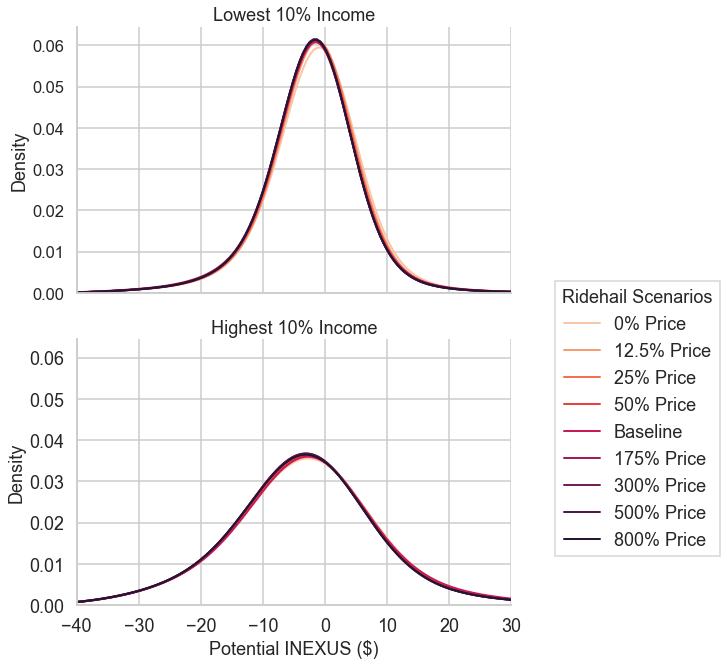

In [160]:
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(r_clean, 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =8, linewidth = 2)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-40,30))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

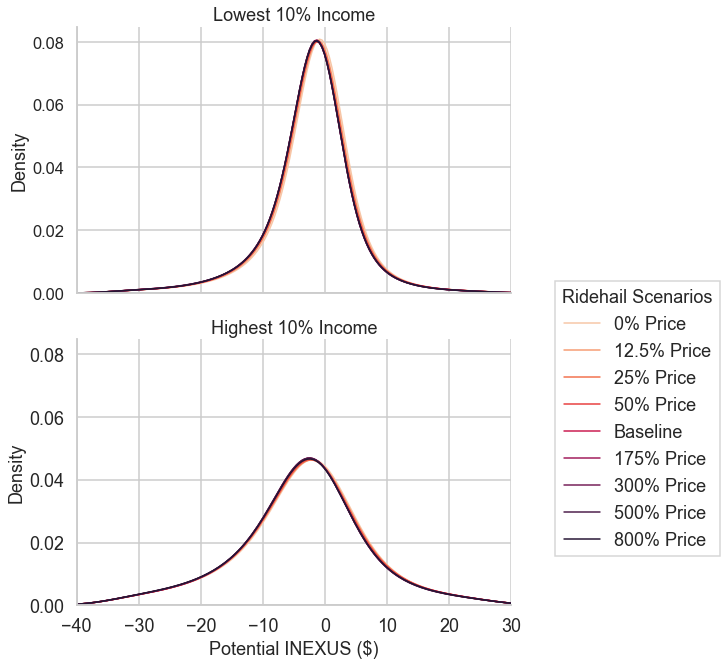

In [161]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(sf_stacked_rh_price_pot_norm.loc[(sf_stacked_rh_price_pot_norm['income_deciles']=='1stD')|
                                                    (sf_stacked_rh_price_pot_norm['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-40,30))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(sf_stacked_rh_price_pot_norm.loc[(sf_stacked_rh_price_pot_norm['income_deciles']=='1stD')|
                                                    (sf_stacked_rh_price_pot_norm['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sf_stacked_rh_price_pot_norm['car_nocar'] = np.where(sf_stacked_rh_price_pot_norm['auto_ownership'] == 0, "nocar", "car")

In [ ]:
sf_stacked_rh_price_cleaned['car_nocar'] = np.where(sf_stacked_rh_price_cleaned['auto_ownership'] == 0, "nocar", "car")

In [ ]:
len(sf_stacked_rh_price_cleaned[sf_stacked_rh_price_cleaned['car_nocar'] == "nocar"])

In [ ]:
len(sf_stacked_rh_price_cleaned[sf_stacked_rh_price_cleaned['car_nocar'] == "car"])

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(filtered_df,  
                     hue='lever_position', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar', bw_adjust =2.5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

#for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    #ax.set_title(title)

#grid.set(xlim=(-4,3))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income.svg', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income.png', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(filtered_df,  
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =2.5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

#for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    #ax.set_title(title)

#grid.set(xlim=(-4,3))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income.svg', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income.png', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(small_stacked_rh_price.loc[(small_stacked_rh_price['income_deciles']=='1stD')|
                                            (small_stacked_rh_price['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'logsum_trip_Potential_INEXUS', bw_adjust =2.5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-4,3))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
plt.savefig('potential_income.svg', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
plt.savefig('potential_income.png', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
#PRGn   PiYG  PuOr RdBu  RdGy_r RdYlBu  RdYlGn  YlGnBu   mako  BuGn YlGn_r

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[(sf_stacked_rh_price['income_deciles']=='1stD')|
                                            (sf_stacked_rh_price['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position', height=5, aspect=1.5, palette = "RdYlGn", legend_out=True )
grid.map(sns.kdeplot, 'Realized_INEXUS_in_dollar', bw_adjust =3)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-80,50))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Realized INEXUS in dollar', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
plt.savefig('potential_income.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[(sf_stacked_rh_price['income_deciles']=='1stD')|
                                            (sf_stacked_rh_price['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position', height=5, aspect=1.5, palette = "RdYlGn", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar', bw_adjust =4)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-60,40))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [ ]:
c = sf_stacked_rh_price.groupby(['income_deciles','lever_position'])['Potential_INEXUS_in_dollar'].describe()

In [ ]:
c.to_csv('C:/Shared-Work/Data/CleanData/Potential_Inc_lever_describe.csv')

In [ ]:
a = sf_stacked_rh_price_pot_norm[(sf_stacked_rh_price_pot_norm['income_deciles']=='1stD')|(sf_stacked_rh_price_pot_norm['income_deciles']=='10thD')]

In [ ]:
b = a[a['lever_position_price']==1]

In [ ]:
d = b[(b['mandatoryCat']=='from_M_to_M')|(b['mandatoryCat']=='from_M_to_H')|(b['mandatoryCat']=='from_H_to_M')]

In [ ]:
#t = sf_stacked_rh_price[sf_stacked_rh_price['lever_position']==1]

In [ ]:
#y = t[(t['mandatoryCat']=='from_M_to_M')|(t['mandatoryCat']=='from_M_to_H')|(t['mandatoryCat']=='from_H_to_M')]

In [ ]:
sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'].describe()

In [ ]:
sf_stacked_rh_price_pot_norm = sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] < 50)&
                               (sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar_2023'] > -70)]

In [ ]:
sf_stacked_rh_price_pot_norm['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
base = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['lever_position_price'] == 1]

In [ ]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

ax=sns.kdeplot(data=base, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, alpha=0.1, color="#CC3311", bw_adjust =37, linewidth =5)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)
plt.legend(labels = ['Baseline Scenario'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlim(-200, 170)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=base, x="Potential_INEXUS_in_dollar_2023", hue = 'mode_choice_actual_4', 
            fill=True, common_norm=False, common_grid = False, palette=color_dict.values(), alpha=0.1, bw_adjust =25, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-280, 250)

plt.legend(labels = ['Ridehail', 'Transit', 'Walk/Bike', 'Car'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
base.groupby('mode_choice_actual_4')['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=base, x="Potential_INEXUS_in_dollar_2023", hue = 'mode_choice_actual_4', 
            fill=True, common_norm=False, common_grid = False, palette=color_dict.values(), alpha=0.1, bw_adjust =25, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-280, 250)

plt.legend(labels = ['Ridehail', 'Transit', 'Walk/Bike', 'Car'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
base['car_nocar'] = np.where(base['auto_ownership'] == 0, "nocar", "car")

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=base, x="Potential_INEXUS_in_dollar", hue = 'car_nocar',
            fill=True, common_norm=False, alpha=0.05,bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
b.groupby('income_deciles').size()

In [ ]:
b.groupby('income_deciles')['Potential_INEXUS_in_dollar'].describe()

In [ ]:
base.lever_position_price.unique()

In [ ]:
base[base['income_deciles']=='1stD']['Potential_INEXUS_in_dollar_2023'].mean()

In [ ]:
base[base['income_deciles']=='10thD']['Potential_INEXUS_in_dollar_2023'].mean()

In [ ]:
base['mand_cat'] = np.where(base['mandatoryCat'].isin(['from_M_to_M', 'from_M_to_H', 'from_H_to_M']), 'mand', 'non-mand')

In [ ]:
base.groupby('mand_cat')['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=base, x="Potential_INEXUS_in_dollar_2023", hue = 'mand_cat',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('mako', n_colors=2), bw_adjust =30, linewidth =5)
sns.move_legend(ax, labels = ['Mandatory trips','Non-mandatory trips'], loc="best", ncol=1, title=None, frameon=True, fontsize = 28)#, bbox_to_anchor=(1.25, 0.6), 

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-160, 130)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sf_stacked_rh_price_cleaned.logsum_trip_Potential_INEXUS.describe()

In [ ]:
z_scores = np.abs((sf_stacked_rh_price_cleaned['logsum_trip_Potential_INEXUS'] - sf_stacked_rh_price_cleaned['logsum_trip_Potential_INEXUS'].mean()) / sf_stacked_rh_price_cleaned['logsum_trip_Potential_INEXUS'].std())

In [ ]:
z_scores_dollar = np.abs((sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar'] - sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar'].mean()) / sf_stacked_rh_price_cleaned['Potential_INEXUS_in_dollar'].std())

In [ ]:
threshold = 3

In [ ]:
df_dollar = sf_stacked_rh_price_cleaned[z_scores_dollar <= threshold]

In [ ]:
df = sf_stacked_rh_price_cleaned[z_scores <= threshold]

In [ ]:
df.logsum_trip_Potential_INEXUS.describe()

In [ ]:
sf_stacked_rh_price_pot_out = sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['logsum_trip_Potential_INEXUS'] < 10)&
                               (sf_stacked_rh_price_cleaned['logsum_trip_Potential_INEXUS'] > -20)]

In [ ]:
df_dollar_base = df_dollar[df_dollar['lever_position_price'] == 1]

In [ ]:
df_base = df[df['lever_position_price'] == 1]

In [ ]:
sf_stacked_rh_price_cleaned[sf_stacked_rh_price_cleaned['actPurpose']=='Home_to_work'].groupby('income_deciles')['alpha'].describe()

In [ ]:
df_dollar_base.groupby('income_deciles')['logsum_trip_Potential_INEXUS'].describe()

In [ ]:
df_dollar_base.groupby('income_deciles')['Potential_INEXUS_in_dollar'].describe()

In [ ]:
base.groupby('income_deciles')['logsum_trip_Potential_INEXUS'].describe()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=base[(base['income_deciles']=='1stD')|(base['income_deciles']=='10thD')], x="Potential_INEXUS_in_dollar_2023", hue = 'income_deciles',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=df_dollar_base[(df_dollar_base['income_deciles']=='1stD')|(df_dollar_base['income_deciles']=='10thD')], x="logsum_trip_Potential_INEXUS", hue = 'income_deciles',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=sf_stacked_rh_price_pot_norm[(sf_stacked_rh_price_pot_norm['income_deciles']=='1stD')|(sf_stacked_rh_price_pot_norm['income_deciles']=='10thD')], x="Potential_INEXUS_in_dollar", hue = 'income_deciles',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=sf_stacked_rh_price_pot_norm[(sf_stacked_rh_price_pot_norm['income_deciles']=='1stD')|(sf_stacked_rh_price_pot_norm['income_deciles']=='10thD')], x="logsum_trip_Potential_INEXUS", hue = 'income_deciles',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sf_stacked_rh_price_pot_norm_realized = sf_stacked_rh_price_cleaned[(sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] < 20)&
                               (sf_stacked_rh_price_cleaned['Realized_INEXUS_in_dollar_2023'] > -200)]

In [ ]:
base_realized = sf_stacked_rh_price_pot_norm_realized[sf_stacked_rh_price_pot_norm_realized['lever_position_price']==1]

In [ ]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=base_realized[(base_realized['income_deciles']=='1stD')|(base_realized['income_deciles']=='10thD')], x="Realized_INEXUS_in_dollar_2023", hue = 'income_deciles',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-100, 70)
plt.xlabel('Realized INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Highest 10% Income','Lowest 10% Income'], loc="best", fontsize=28),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1], x="logsum_trip_Potential_INEXUS", hue = 'auto_ownership',
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=5), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-20, 15)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization
#scaler = StandardScaler()
#normalized_data = scaler.fit_transform(sf_stacked_rh_price)

# Min-max scaling
#scaler = MinMaxScaler(feature_range=(0, 1))
#normalized_data = scaler.fit_transform(sf_stacked_rh_price)

In [ ]:
from scipy.stats import zscore

normalized_data = sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1].groupby('mode_choice_actual_4').transform(zscore)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1], x="logsum_trip_Potential_INEXUS", hue = 'mode_choice_actual_4',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('rocket_r', n_colors=4), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-20, 15)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")

ax=sns.kdeplot(data=sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position'] == 1], x="logsum_trip_Potential_INEXUS",  
            fill=True, color='r', common_norm=False, alpha=0.1, bw_adjust =15, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-7, 5)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_income_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
a['Potential_INEXUS_in_dollar'].describe()

In [ ]:
sns.set()
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=b, x="Potential_INEXUS_in_dollar", hue="income_deciles", 
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =1)

sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="center", bbox_to_anchor=(0.5, -0.2), ncol=2, title=None, frameon=True)

plt.xlim(-60, 40)
plt.xlabel('Potential INEXUS in dollar', fontsize=18)
plt.ylabel('Frequency Density', fontsize=18)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=d, x="logsum_trip_Potential_INEXUS", hue="income_deciles", 
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =9, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-7, 5)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_income_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set()
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=d.loc[d["Realized_INEXUS_in_dollar"]>-100], x="Realized_INEXUS_in_dollar", hue="income_deciles", 
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-60, 40)
plt.xlabel('Realized INEXUS in dollar', fontsize=18)
plt.ylabel('Frequency Density', fontsize=18)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('Fig2.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=25),), bbox_inches='tight')

In [ ]:
mand = d.groupby(['income_deciles','lever_position'])['Potential_INEXUS_in_dollar'].describe()

In [ ]:
whole = b.groupby(['income_deciles','lever_position'])['Potential_INEXUS_in_dollar'].describe()

In [ ]:
mand

In [ ]:
whole

#### Line Plot Potential - Mode - Income

In [ ]:
sf_stacked_rh_price['denial'] = np.where(sf_stacked_rh_price['replanning_status'] > 0, 1, 0)

In [ ]:
sf_stacked_rh_price.head()

In [ ]:
tour_cat_plot['denial'] = np.where(tour_cat_plot['replanning_status'] > 0, 1, 0)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'denial', hue ='tour_category',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Ridehail Denial of Service')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
tour_cat_plot['waitTime_min'] = tour_cat_plot['waitTime']/60

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'waitTime_min', hue ='tour_category',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Wait Time (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'distance_travelling', hue ='tour_category',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Distance Travelling')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
tour_cat_plot['duration_travelling_min'] = tour_cat_plot['duration_travelling']/60

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'duration_travelling', hue ='tour_category',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Duration Travelling (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'duration_travelling', hue ='income_level',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Duration Travelling (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'waitTime_min', hue ='income_level',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Wait Time (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_BEAM']=='ride_hail'], x = 'lever_position', y = 'waitTime_min', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Wait Time (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_BEAM']=='ride_hail_pooled'], x = 'lever_position', y = 'waitTime_min', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Wait Time (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'distance_travelling', hue ='income_level',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Distance Travelling')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'Potential_INEXUS_in_dollar', hue ='income_level',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Potential INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = tour_cat_plot.loc[tour_cat_plot['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'Realized_INEXUS_in_dollar', hue ='income_level',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Realized INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
t = tour_cat_plot[(tour_cat_plot['income_deciles']=='1stD')|(tour_cat_plot['income_deciles']=='10thD')]

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'Realized_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Realized INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'distance_travelling', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Distance Travelling')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
t ['waitTime_min'] = t['waitTime']/60

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'waitTime_min', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Wait Time (min)')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='transit'], x = 'lever_position', y = 'Realized_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Realized INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='car'], x = 'lever_position', y = 'Realized_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Realized INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='walk/bike'], x = 'lever_position', y = 'Realized_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Realized INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='car'], x = 'lever_position', y = 'Potential_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Potential INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_4']=='ride_hail'], x = 'lever_position', y = 'Potential_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Potential INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_BEAM']=='ride_hail'], x = 'lever_position', y = 'Potential_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Potential INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = t.loc[t['mode_choice_actual_BEAM']=='ride_hail_pooled'], x = 'lever_position', y = 'Potential_INEXUS_in_dollar', hue ='income_deciles',
                 palette = 'turbo', marker='o', ci=None)
ax.set(xlabel='Ridehail Price Scenarios', ylabel='Potential INEXUS in dollar')
plt.legend(bbox_to_anchor = (1.40, 1.02), fontsize = 10)

In [ ]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(t, 
                     row = 'mode_choice_actual_4' , row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     height=5.2, aspect=1.5, palette = "rocket_r")
grid = grid.map(sns.lineplot, 'lever_position','Potential_INEXUS_in_dollar', 'income_deciles', marker='o',ci=None, 
               legend='brief')


for ax, title in zip(grid.axes.flat, ['Ridehail', 
                                     'Car',
                                     'Transit',
                                     'Walk/Bike']):
    ax.set_title(title)
    
plt.legend(title="Income Level", labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.6, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-60,50))

grid.set_ylabels('Potential INEXUS in dollar', size=18)
grid.set_xlabels('Ridehail Scenarios', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

In [ ]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(t, 
                     row = 'mode_choice_actual_4' , row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     height=5.2, aspect=1.5, palette = "rocket_r")
grid = grid.map(sns.lineplot, 'lever_position','Realized_INEXUS_in_dollar', 'income_deciles', marker='o',ci=None, 
               legend='brief')


for ax, title in zip(grid.axes.flat, ['Ridehail', 
                                     'Car',
                                     'Transit',
                                     'Walk/Bike']):
    ax.set_title(title)
    
plt.legend(title="Income Level", labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.6, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-60,50))

grid.set_ylabels('Realized INEXUS in dollar', size=18)
grid.set_xlabels('Ridehail Scenarios', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

In [ ]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(t, 
                     row = 'mode_choice_actual_4' , row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     height=5.2, aspect=1.5, palette = "rocket_r")
grid = grid.map(sns.lineplot, 'lever_position','waitTime_min', 'income_deciles', marker='o',ci=None, 
               legend='brief')


for ax, title in zip(grid.axes.flat, ['Ridehail', 
                                     'Car',
                                     'Transit',
                                     'Walk/Bike']):
    ax.set_title(title)
    
plt.legend(title="Income Level", labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.6, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-60,50))

grid.set_ylabels('Wait Time (min)', size=18)
grid.set_xlabels('Ridehail Scenarios', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

In [ ]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')
grid = sns.FacetGrid(t, 
                     row = 'mode_choice_actual_4' , row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     height=5.2, aspect=1.5, palette = "rocket_r")
grid = grid.map(sns.lineplot, 'lever_position','distance_travelling', 'income_deciles', marker='o',ci=None, 
               legend='brief')


for ax, title in zip(grid.axes.flat, ['Ridehail', 
                                     'Car',
                                     'Transit',
                                     'Walk/Bike']):
    ax.set_title(title)
    
plt.legend(title="Income Level", labels = ['Highest 10% Income', 'Lowest 10% Income'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.6, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-60,50))

grid.set_ylabels('Distance Travelling', size=18)
grid.set_xlabels('Ridehail Scenarios', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

#### Density Plots

In [ ]:
#no replanning
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[sf_stacked_rh_price['mode_choice_actual_BEAM']==sf_stacked_rh_price['mode_choice_planned_BEAM']], 
                     row = 'mode_choice_actual_4' , col='income_level', 
                     hue='lever_position', height=5.2, aspect=1.5, palette=sns.color_palette('rocket_r', n_colors=8), legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar')

#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))

grid.add_legend()
#handles, _ = grid.get_legend_handles_labels()   # Get the artists.
#grid.add_legend(handles, ['0% Price', '25% Price','50% Price','Baseline','150% Price','200% Price'], loc="best")   
    
#grid.map(vertical_mean_line_survived, 'Realized_INEXUS_in_dollar') 

grid.set(xlim=(-100,sf_stacked_rh_price['Potential_INEXUS_in_dollar'].max()))

grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS (dollar)', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [ ]:
# Replanning
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[sf_stacked_rh_price['mode_choice_actual_BEAM']!=sf_stacked_rh_price['mode_choice_planned_BEAM']], 
                     row = 'mode_choice_actual_4' , col='income_level', 
                     hue='lever_position', height=5.2, aspect=1.5, palette = "turbo", legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar')

#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))

grid.add_legend()
#handles, _ = grid.get_legend_handles_labels()   # Get the artists.
#grid.add_legend(handles, ['0% Price', '25% Price','50% Price','Baseline','150% Price','200% Price'], loc="best")   
    
#grid.map(vertical_mean_line_survived, 'Realized_INEXUS_in_dollar') 

grid.set(xlim=(-60,sf_stacked_rh_price['Potential_INEXUS_in_dollar'].max()))

grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS (dollar)', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [ ]:
sf_stacked_rh_price.isnull().sum().sort_values(ascending=False)

C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\nrezaei\anaconda3\envs\BEAM-COR

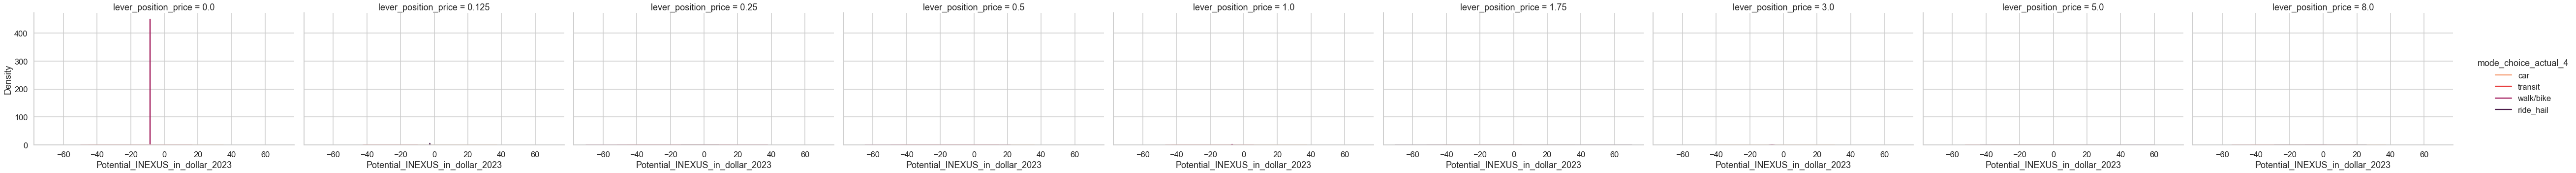

In [132]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
                                                      
grid = sns.FacetGrid(sf_stacked_rh_price_pot_norm.head(1000), 
                     col='lever_position_price', 
                     hue='mode_choice_actual_4', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023')

#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))

grid.add_legend()
#handles, _ = grid.get_legend_handles_labels()   # Get the artists.
#grid.add_legend(handles, ['0% Price', '25% Price','50% Price','Baseline','150% Price','200% Price'], loc="best")   
    
#grid.map(vertical_mean_line_survived, 'Realized_INEXUS_in_dollar') 

#grid.set(xlim=(-100,sf_stacked_rh_price['Potential_INEXUS_in_dollar_2023'].max()))

#grid.set_ylabels('Density', size=18)
#grid.set_xlabels('Potential INEXUS (dollar)', size=18)

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')

In [133]:
r = same_mode_actual[(same_mode_actual['income_deciles'] == '1stD')|(same_mode_actual['income_deciles'] == '10thD')]

In [151]:
r_clean = r[(r['Potential_INEXUS_in_dollar_2023']>-50)&(r['Potential_INEXUS_in_dollar_2023']<40)&
            (r['Realized_INEXUS_in_dollar_2023']>-40)&(r['Realized_INEXUS_in_dollar_2023']<30)]

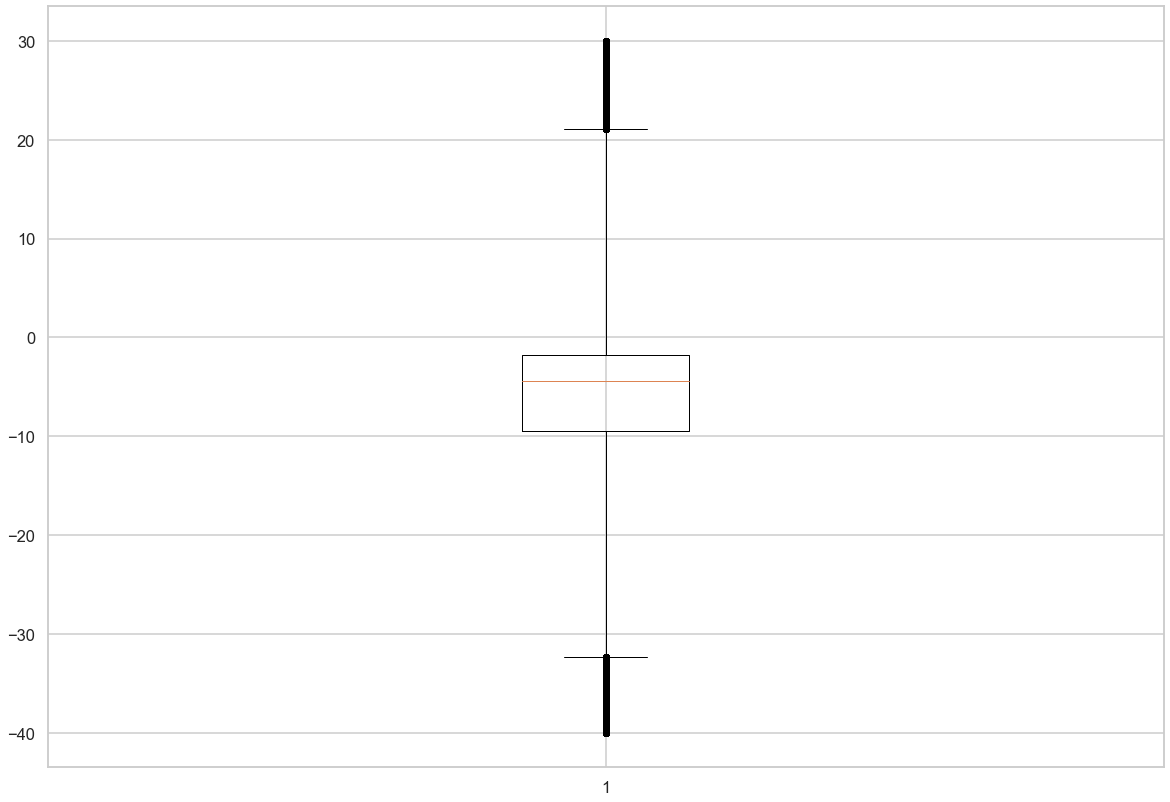

In [152]:
plt.boxplot(r_clean['Realized_INEXUS_in_dollar_2023'], whis=3)
plt.show()

In [ ]:
u = diff_mode_actual[(diff_mode_actual['income_deciles'] == '1stD')|(diff_mode_actual['income_deciles'] == '10thD')]

In [ ]:
s = r[r['mode_choice_actual_4']=='ride_hail']

In [ ]:
sf_stacked_rh_price.groupby(['income_deciles','lever_position'])['Potential_INEXUS_in_dollar'].describe()

In [ ]:
i.to_csv('C:/Shared-Work/Data/CleanData/Potential_income_new_describe.csv')

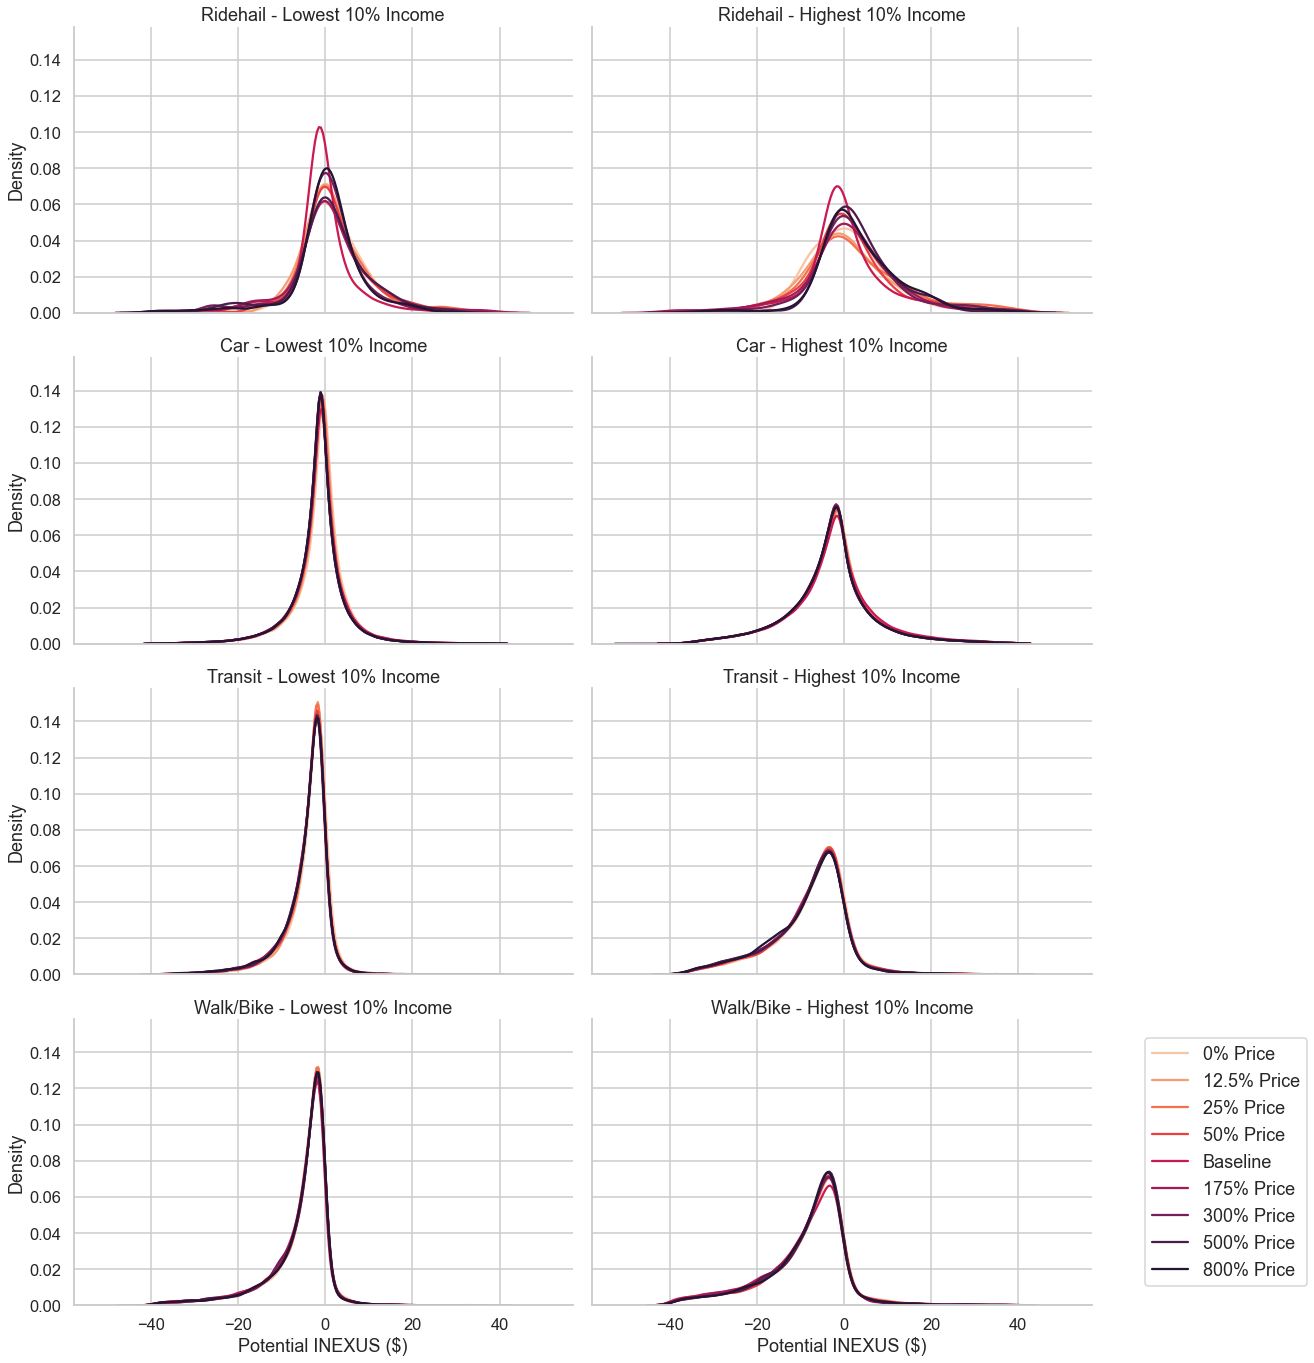

In [153]:
# Same planned mode as baseline
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(r_clean, 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position_price', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =1)

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-150,50))

grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[(sf_stacked_rh_price['income_deciles']=='1stD')|
                                            (sf_stacked_rh_price['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'logsum_trip_Potential_INEXUS', bw_adjust =1)

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-8,5))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(same_mode_actual.loc[(same_mode_actual['income_deciles']=='1stD')|
                                            (same_mode_actual['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'logsum_trip_Potential_INEXUS', bw_adjust =1)

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-8,5))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(diff_mode_actual.loc[(diff_mode_actual['income_deciles']=='1stD')|
                                            (diff_mode_actual['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'logsum_trip_Potential_INEXUS')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-8,5))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(diff_mode_actual_ridehail.loc[(diff_mode_actual_ridehail['income_deciles']=='1stD')|
                                            (diff_mode_actual_ridehail['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'logsum_trip_Potential_INEXUS')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-10,5))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(sf_stacked_rh_price.loc[(sf_stacked_rh_price['income_deciles']=='1stD')|
                                            (sf_stacked_rh_price['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Realized_INEXUS_in_dollar')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-80,50))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Realized INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(same_mode_actual.loc[(same_mode_actual['income_deciles']=='1stD')|
                                            (same_mode_actual['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Realized_INEXUS_in_dollar')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-80,50))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Realized INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(diff_mode_actual.loc[(diff_mode_actual['income_deciles']=='1stD')|
                                            (diff_mode_actual['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Realized_INEXUS_in_dollar')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-100,50))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Realized INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(diff_mode_actual_ridehail.loc[(diff_mode_actual_ridehail['income_deciles']=='1stD')|
                                            (diff_mode_actual_ridehail['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Realized_INEXUS_in_dollar')

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set(xlim=(-100,50))

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Realized INEXUS in dollar', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
# Different planned mode from baseline
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')
grid = sns.FacetGrid(u, 
                     row = 'mode_choice_actual_4' , col='income_deciles', 
                     hue='lever_position', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar')

for ax, title in zip(grid.axes.flat, ['Ridehail -High Income', 'Ridehail - Low Income', 
                                     'Car - High Income', 'Car - Low Income',
                                     'Transit - High Income', 'Transit - Low Income',
                                     'Walk/Bike - High Income','Walk/Bike - Low Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

grid.set_ylabels('Frequency Density', size=18)
grid.set_xlabels('Potential INEXUS in dollar', size=18)

grid.set(xlim=(-60,50))

# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
plt.savefig('potential_modes_diff.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
y = sf_stacked_rh_price[(sf_stacked_rh_price['trip_mode_AS_trips']=='DRIVEALONEPAY')|(sf_stacked_rh_price['trip_mode_AS_trips']=='DRIVEALONEFREE')]

In [ ]:
x = y[y['DRIVEALONEPAY']<-1000].head(100)

In [ ]:
x.to_csv('C:/Shared-Work/Data/CleanData/checkCarUtils.csv')

In [ ]:
sf_stacked_rh_price.trip_mode_AS_trips.unique()

#### Figure 8 - Income_Rank INEXUS plot

In [104]:
def process_income_data(dataframe):
    small_stacked_rh_price = dataframe[['lever_position_price','income_deciles','IDMerged','tripIndex',
                                        'income', 'realized_in_dollar_2023_relative_to_baseline', 
                                        'Realized_INEXUS_in_dollar_2023', 'potential_in_dollar_2023_relative_to_baseline',
                                        'Potential_INEXUS_in_dollar_2023', 'mode_choice_actual_4', 'duration_door_to_door',
                                        'waitTime_no_replanning','waitTime_replanning', 'mode_choice_planned_BEAM',
                                        'mode_choice_actual_BEAM','mode_actual_baseline']]
    
    small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000
    
    person_income = pd.pivot_table(
        small_stacked_rh_price,
        index=['IDMerged'],
        aggfunc={'incomeInThousands': lambda x: ', '.join(set(x.dropna().astype(str)))}).reset_index()
    
    person_income['incomeInThousands'] = person_income['incomeInThousands'].astype(float)
    
    twenty_one_ranks = person_income['incomeInThousands'].quantile([
        0, 0.048, 0.095, 0.143, 0.191, 0.239, 0.287, 0.335, 0.383, 0.431, 0.479,
        0.527, 0.575, 0.623, 0.671, 0.719, 0.767, 0.815, 0.863, 0.911, 0.959, 1
    ]).tolist()
    
    conditions = [
        (person_income['incomeInThousands'] >= twenty_one_ranks[i]) & 
        (person_income['incomeInThousands'] <= twenty_one_ranks[i+1])
        for i in range(21)
    ]
    
    choices = list(range(21))
    
    person_income['incomeRank'] = np.select(conditions, choices, default=None)
    
    smaller_stacked_rh_price = pd.merge(left = small_stacked_rh_price, right = person_income, how='left', on = ['IDMerged'], suffixes=('', '_drop'))
    smaller_stacked_rh_price.drop([col for col in smaller_stacked_rh_price.columns if 'drop' in col], axis=1, inplace=True)
    
    lorenz_data = pd.pivot_table(
        smaller_stacked_rh_price,
        index=['lever_position_price', 'incomeRank'],
        aggfunc={'incomeInThousands': np.mean,
                 'Potential_INEXUS_in_dollar_2023': np.mean,
                 'Realized_INEXUS_in_dollar_2023': np.mean,
                 'realized_in_dollar_2023_relative_to_baseline': np.mean,
                 'potential_in_dollar_2023_relative_to_baseline': np.mean}).reset_index() 
    return lorenz_data

In [106]:
lorenz_data = process_income_data(sf_stacked_rh_price)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_1988\2388425759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000


In [111]:
palette = {
    8: '#521e4d',
    5: '#8e1d5b',
    3: '#ad1759',
    1.75: '#ca1a50',
    1: '#e13243',
    0.5: '#ee543f',
    0.25: '#f37751',
    0.125: '#f5966d',
    0: '#f7d0b5'}

In [109]:
lorenz_data['incRank_percent'] = (lorenz_data['incomeRank'])*5

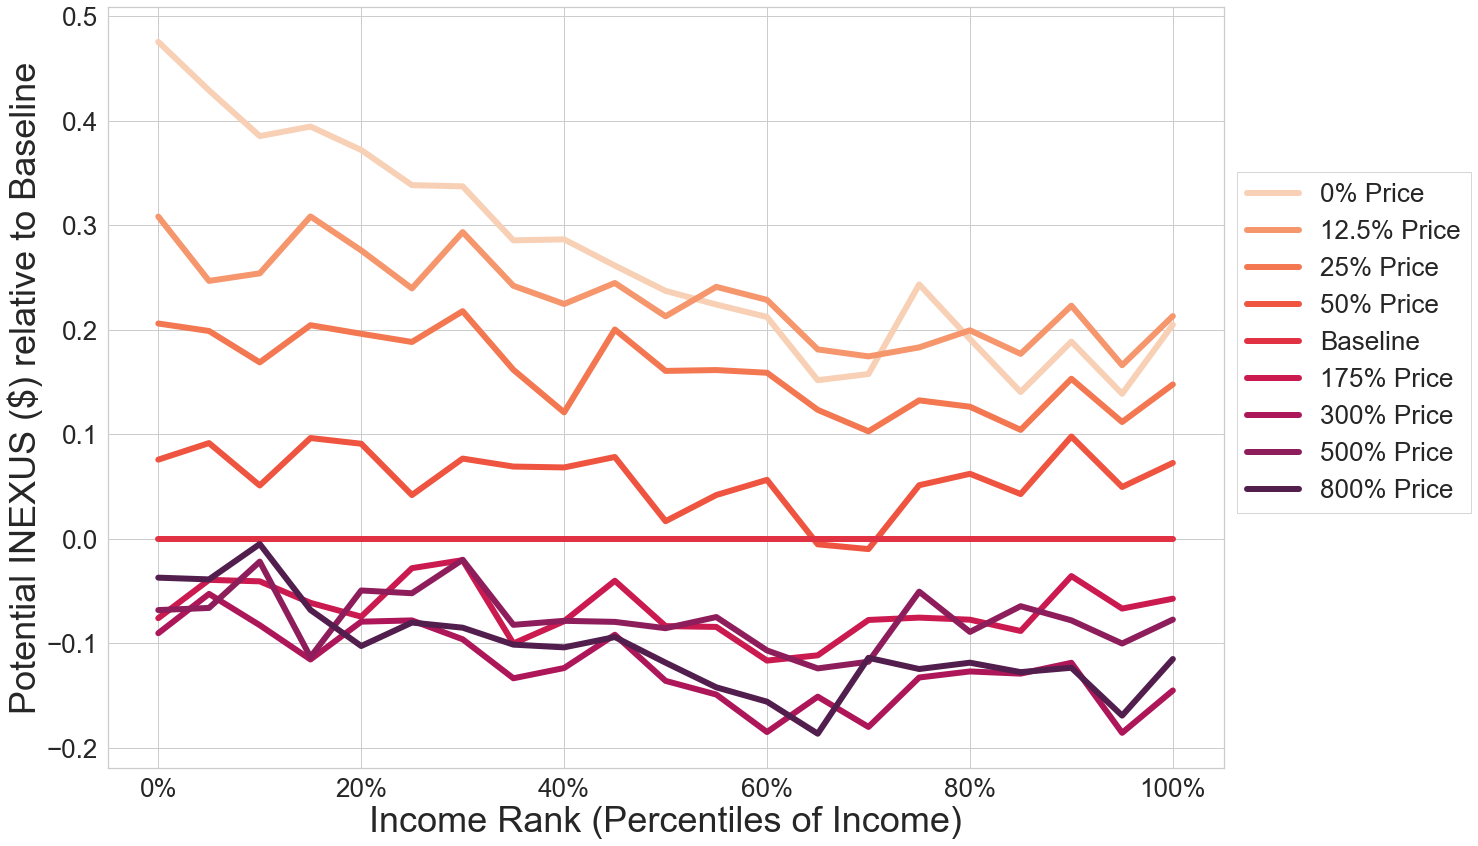

In [118]:
import matplotlib.ticker as ticker
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = df_lorenz, x = (lorenz_data['incomeRank'])*5, 
                  y = 'potential_in_dollar_2023_relative_to_baseline', hue = 'lever_position_price', palette = palette, ci=None, linewidth = 6)
ax.set_xlabel('Income Rank (Percentiles of Income)', fontsize = 36) #45
ax.set_ylabel('Potential INEXUS ($) relative to Baseline', fontsize = 36) #45
ax.yaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}%'))
plt.legend(labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 26}) #35
plt.savefig('lorenz.png', format='png', dpi=300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], fancybox=False, bbox_to_anchor=(1, 0.8), fontsize=26),), bbox_inches='tight') #30
#plt.savefig('lorenz.png', dpi=300)

#### last plot

In [3]:
# get the quartiles of the distance column
quartiles = np.percentile(sf_stacked_rh_price_clean1['distance_travelling'], [25, 50, 75])

# set the cutoffs based on the quartiles
cutoffs = [0, quartiles[0], quartiles[1], quartiles[2], float('inf')]

# label the distances based on the cutoffs
sf_stacked_rh_price_clean1['distance_label'] = pd.cut(sf_stacked_rh_price_clean1['distance_travelling'], bins=cutoffs, labels=['short', 'medium', 'long', 'extra-long'])

NameError: name 'sf_stacked_rh_price' is not defined

In [ ]:
sf_stacked_rh_price_clean1['distance_group'] = pd.qcut(sf_stacked_rh_price_clean1['distance_travelling'], q=3, labels=['short', 'medium', 'long'])

In [ ]:
base2 = sf_stacked_rh_price_clean1[sf_stacked_rh_price_clean1['lever_position_price'] == 1]

In [ ]:
sf_stacked_rh_price_clean1.groupby('distance_group')['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
#color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=base2, x="Potential_INEXUS_in_dollar_2023", hue = 'distance_group', 
            fill=True, common_norm=False, common_grid = False, palette='rocket_r', alpha=0.05, bw_adjust =25, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-200, 170)

plt.legend(title = 'Distance', labels = ['Long','Medium','Short'],
        fontsize='small', title_fontsize = 30, fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sf_stacked_rh_price_clean1['duration_group'] = pd.qcut(sf_stacked_rh_price_clean1['duration_travelling'], q=3, labels=['short', 'medium', 'long'])

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
#color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=base2, x="Potential_INEXUS_in_dollar_2023", hue = 'distance_group', 
            fill=True, common_norm=False, common_grid = False, palette='rocket_r', alpha=0.05, bw_adjust =25, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlim(-200, 170)

plt.legend(title = 'Travel Time', labels = ['Long','Medium','Short'],
        fontsize='small', title_fontsize = 30, fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
%%time
# Create a density plot of the "realized" and "potential" variables
sns.kdeplot(data=df_clean_0p01, x="Realized_INEXUS_in_dollar_2023", fill=True, alpha=0.1, color="blue", legend = True, linewidth =5)
sns.kdeplot(data=df_clean_0p01, x="Potential_INEXUS_in_dollar_2023", fill=True, alpha=0.1, color="orange", legend = True, linewidth =5)

# Set plot title and axis labels
plt.title("Comparison of Realized and Potential INEXUS")
plt.xlabel("INEXUS Value")
plt.ylabel("Density")

plt.legend(labels = ['Realized INEXUS','Potential INEXUS'],
        fontsize='small', title_fontsize = 30, fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32})

# Show the plot
plt.show()